<a href="https://colab.research.google.com/github/kokeitor/COMPAS_BIAS/blob/main/compas_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  pandas numpy matplotlib seaborn scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluación del Sesgo en el Algoritmo COMPAS

## Introducción

En este notebook, se llevará a cabo un análisis exhaustivo del sesgo presente en el algoritmo COMPAS (Correctional Offender Management Profiling for Alternative Sanctions). COMPAS es una herramienta ampliamente utilizada en el sistema de justicia penal de los Estados Unidos para evaluar la probabilidad de reincidencia de los acusados. Esta herramienta proporciona puntuaciones de riesgo que son utilizadas por jueces y oficiales de libertad condicional para tomar decisiones informadas sobre la detención, sentencia y liberación de los acusados.

### Contexto del Algoritmo COMPAS

COMPAS utiliza una serie de factores, incluyendo datos demográficos y antecedentes penales, para generar una puntuación de riesgo (campo  * decile_score* en el dataset) que varía entre 1 y 10. Este puntuación indica la probabilidad de que un individuo cometa un nuevo delito en el futuro. Sin embargo, estudios recientes han planteado preocupaciones significativas sobre la equidad de COMPAS, señalando que el algoritmo puede estar sesgado en contra de ciertos grupos demográficos, especialmente los afroamericanos.

### Objetivo del Análisis

El objetivo principal de este análisis es evaluar el sesgo racial en el algoritmo COMPAS, específicamente cómo afecta a los individuos afroamericanos en comparación con otros grupos demográficos. Tambien se compara e investiga otro posible sesgo existente dentro de la feature de género o "sex" en el dataset. Para lograr esto, se llevarán a cabo las siguientes tareas:

1. **Exploración y transformación de Datos**: Se analizará el conjunto de datos de manera visual y estadística para comprender su estructura y características. incluye drop de ciertas variables no útiles, codificación de variables y establecimiento de un threshold para las probabilidades otrogadas por COMPAS. De esta forma se logra una nueva columna *compas_recid* binaria para comparar con el ground truth de reincidencia (*is_recid*).
2. **Modelo *custom***: Crea y entrena una pipeline con la que depués se predice. Esta pipeline incluye un modelo ensamblado binario. Las predicciones de este modelo se usan para comparar y evaluar el sesgo de COMPAS.
3. **Cálculo de Métricas de Rendimiento**: Se evaluará la precisión, recall, F1-score, y otras métricas del modelo COMPAS y del custom y se compararán.
4. **Análisis de la Matriz de Confusión**: Se compararán las tasas de falsos positivos (FP) y falsos negativos (FN) entre diferentes grupos raciales y entre ambos modelos.
5. **Curvas ROC**: Se generarán y analizarán las curvas ROC para distintos grupos demográficos.
6. **Identificación de Disparidades**: Se identificarán y cuantificarán las disparidades en las tasas de error de predicción entre los grupos demográficos. Y entre los géneros.
7. **Recomendaciones**: Se proporcionarán recomendaciones sobre cómo abordar los sesgos identificados en el modelo COMPAS y posibles siguientes pasos.


### Estructura del Notebook

1. **Carga de Datos y Preprocesamiento**: Se importará el conjunto de datos de COMPAS y se realizarán las transformaciones necesarias para su análisis.
2. **Exploración de Datos**: Se visualizarán y describirán las características principales del conjunto de datos.
3. **Entrenamiento de Modelos**: Se entrenará un modelo "custom" y se comparará su rendimiento con el modelo COMPAS.
4. **Evaluación de Sesgo**: Se realizarán análisis detallados de las métricas de rendimiento y se evaluará el sesgo racial.
5. **Conclusiones y Recomendaciones**: Se discutirán los resultados obtenidos y se proporcionarán recomendaciones para abordar los sesgos identificados.

A lo largo de este notebook, no solo se buscará identificar los sesgos presentes, sino también proporcionar un marco para mitigarlos, asegurando así que las herramientas de evaluación de riesgos sean más justas y equitativas.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [63]:
data = pd.read_csv('/content/drive/MyDrive/MásterIA/etica/data/cox-violent-parsed.csv')

In [64]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11001 non-null  float64
 1   name                     18316 non-null  object 
 2   first                    18316 non-null  object 
 3   last                     18316 non-null  object 
 4   compas_screening_date    18316 non-null  object 
 5   sex                      18316 non-null  object 
 6   dob                      18316 non-null  object 
 7   age                      18316 non-null  int64  
 8   age_cat                  18316 non-null  object 
 9   race                     18316 non-null  object 
 10  juv_fel_count            18316 non-null  int64  
 11  decile_score             18316 non-null  int64  
 12  juv_misd_count           18316 non-null  int64  
 13  juv_other_count          18316 non-null  int64  
 14  priors_count          

In [66]:
data.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event
count,11001.00000,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,17019.000000,17449.000000,18316.000000,6359.000000,0.0,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000,18316.000000
mean,5501.00000,34.019273,0.076873,4.997052,0.098439,0.124263,3.913191,4.302485,57.694596,0.414774,19.961629,NaN,0.073105,4.997052,4.022822,3.913191,186.394901,625.210636,0.044715
std,3175.85949,11.667811,0.464272,2.937569,0.517639,0.524537,5.299864,81.159881,317.994694,0.576449,74.139695,NaN,0.260317,2.937569,2.614189,5.299864,283.373004,335.881439,0.206683
min,1.00000,18.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-597.000000,0.000000,-1.000000,-1.000000,NaN,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,2751.00000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,2.000000,0.000000,0.000000,364.000000,0.000000
50%,5501.00000,31.000000,0.000000,5.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,5.000000,4.000000,2.000000,7.000000,634.000000,0.000000
75%,8251.00000,41.000000,0.000000,8.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,8.000000,6.000000,5.000000,309.000000,897.000000,0.000000
max,11001.00000,96.000000,20.000000,10.000000,13.000000,17.000000,43.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,43.000000,1197.000000,1187.000000,1.000000


In [67]:
data.isnull().sum()

id                          7315
name                           0
first                          0
last                           0
compas_screening_date          0
sex                            0
dob                            0
age                            0
age_cat                        0
race                           0
juv_fel_count                  0
decile_score                   0
juv_misd_count                 0
juv_other_count                0
priors_count                   0
days_b_screening_arrest     1297
c_jail_in                   1297
c_jail_out                  1297
c_case_number                867
c_offense_date              3952
c_arrest_date              15231
c_days_from_compas           867
c_charge_degree              867
c_charge_desc                881
is_recid                       0
r_case_number               9899
r_charge_degree             9899
r_days_from_arrest         11957
r_offense_date              9899
r_charge_desc              10039
r_jail_in 

In [68]:
# Proportion of ground truth recid samples :
data["is_recid"].value_counts()

is_recid
 0    9079
 1    8417
-1     820
Name: count, dtype: int64

In [69]:
# Proportion of compas score samples :
data["decile_score"].value_counts()

decile_score
 1     2923
 2     2031
 4     1830
 3     1813
 7     1720
 6     1713
 9     1670
 5     1649
 8     1614
 10    1330
-1       23
Name: count, dtype: int64

In [70]:
# Drop of -1 values
data = data[data["decile_score"] != -1]

In [71]:
# Proportion of compas score samples [no -1]
data["decile_score"].value_counts()

decile_score
1     2923
2     2031
4     1830
3     1813
7     1720
6     1713
9     1670
5     1649
8     1614
10    1330
Name: count, dtype: int64

In [72]:
# Not needed variables
columns_to_drop = ['id', 'first', 'last', 'in_custody', 'vr_charge_desc', 'r_case_number', 'vr_charge_degree',
                   'c_offense_date', 'c_case_number', 'r_offense_date', 'juv_other_count', 'end', 'event',
                   'screening_date', 'start', 'juv_misd_count', 'juv_fel_count', 'r_days_from_arrest',
                   'r_charge_degree', 'days_b_screening_arrest', 'vr_case_number', 'priors_count.1', 'r_jail_out',
                   'c_arrest_date', 'r_charge_desc', 'r_jail_in', 'violent_recid', 'decile_score.1',
                   'vr_offense_date', 'out_custody']

data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

<ipython-input-72-e525cc116fc8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')


In [73]:
data.columns

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date'],
      dtype='object')

In [74]:
# Date format

data['c_jail_in'] = pd.to_datetime(data['c_jail_in'])
data['c_jail_out'] = pd.to_datetime(data['c_jail_out'])
data['compas_screening_date'] = pd.to_datetime(data['compas_screening_date'])
data['v_screening_date'] = pd.to_datetime(data['v_screening_date'])
data['days_in_jail'] = abs((data['c_jail_out'] - data['c_jail_in']).dt.days)

<ipython-input-74-59e902b9847f>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['c_jail_in'] = pd.to_datetime(data['c_jail_in'])
<ipython-input-74-59e902b9847f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['c_jail_in'] = pd.to_datetime(data['c_jail_in'])
<ipython-input-74-59e902b9847f>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['c_jail_out'] = pd.to_datetime(data['c_jail_out'])
<ipython-input-74-59e902b9847f>:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (t

In [75]:
# Checking change of date types
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18293 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18293 non-null  object        
 1   compas_screening_date  18293 non-null  datetime64[ns]
 2   sex                    18293 non-null  object        
 3   dob                    18293 non-null  object        
 4   age                    18293 non-null  int64         
 5   age_cat                18293 non-null  object        
 6   race                   18293 non-null  object        
 7   decile_score           18293 non-null  int64         
 8   priors_count           18293 non-null  int64         
 9   c_jail_in              17004 non-null  datetime64[ns]
 10  c_jail_out             17004 non-null  datetime64[ns]
 11  c_days_from_compas     17432 non-null  float64       
 12  c_charge_degree        17432 non-null  object        
 13  c_char

In [76]:
# Null values of dropped data
print("The sum of Null values in each columns ")
data.isnull().sum()

The sum of Null values in each columns 


name                        0
compas_screening_date       0
sex                         0
dob                         0
age                         0
age_cat                     0
race                        0
decile_score                0
priors_count                0
c_jail_in                1289
c_jail_out               1289
c_days_from_compas        861
c_charge_degree           861
c_charge_desc             875
is_recid                    0
is_violent_recid            0
type_of_assessment          0
score_text                  0
v_type_of_assessment        0
v_decile_score              0
v_score_text                0
v_screening_date            0
days_in_jail             1289
dtype: int64

In [77]:
# Imputing null values techniques :
# Median
numeric_cols = ['c_days_from_compas', 'v_decile_score',]
for col in numeric_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Impute missing values for categorical variables with the mode
categorical_cols = ['c_charge_degree', 'score_text', 'v_score_text', 'c_jail_in', 'c_jail_out', 'c_charge_desc', 'days_in_jail']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Checking for any missing values remaining
print(data.isnull().sum())

name                     0
compas_screening_date    0
sex                      0
dob                      0
age                      0
age_cat                  0
race                     0
decile_score             0
priors_count             0
c_jail_in                0
c_jail_out               0
c_days_from_compas       0
c_charge_degree          0
c_charge_desc            0
is_recid                 0
is_violent_recid         0
type_of_assessment       0
score_text               0
v_type_of_assessment     0
v_decile_score           0
v_score_text             0
v_screening_date         0
days_in_jail             0
dtype: int64


In [78]:
# Statistics of new data
data.describe()

,compas_screening_date,age,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,is_recid,is_violent_recid,v_decile_score,v_screening_date,days_in_jail
count,18293,18293.000000,18293.000000,18293.000000,18293,18293,18293.000000,18293.000000,18293.000000,18293.000000,18293,18293.000000
mean,2013-11-23 01:43:12.007871744,34.010605,5.004592,3.916689,2013-11-06 23:32:16.225878784,2013-12-06 16:26:17.885529856,54.948232,0.415241,0.073197,4.023780,2013-11-23 01:43:12.007871744,23.306839
min,2013-01-01 00:00:00,18.000000,1.000000,0.000000,2013-01-01 01:31:00,2013-01-02 01:12:00,0.000000,-1.000000,0.000000,1.000000,2013-01-01 00:00:00,0.000000
25%,2013-04-22 00:00:00,25.000000,2.000000,0.000000,2013-03-30 03:21:00,2013-04-30 07:29:00,1.000000,0.000000,0.000000,2.000000,2013-04-22 00:00:00,0.000000
50%,2013-11-09 00:00:00,31.000000,5.000000,2.000000,2013-10-18 09:30:00,2013-11-13 01:01:00,1.000000,0.000000,0.000000,4.000000,2013-11-09 00:00:00,1.000000
75%,2014-05-29 00:00:00,41.000000,8.000000,5.000000,2014-05-15 10:48:00,2014-06-10 07:56:00,2.000000,1.000000,0.000000,6.000000,2014-05-29 00:00:00,14.000000
max,2014-12-31 00:00:00,96.000000,10.000000,43.000000,2016-03-11 10:26:00,2020-01-01 00:00:00,9485.000000,1.000000,1.000000,10.000000,2014-12-31 00:00:00,2152.000000
std,NaN,11.661140,2.931703,5.302139,NaN,NaN,310.686935,0.576047,0.260467,2.613346,NaN,64.942729


# EDA

A partir de aquí se realiza el EDA sobre el "clean dataset" con el objetivo de visualmente localizar alguna inclinación o mayor proporción de los datos dentro de alguna feature hacia algún valor o categoría que luego impacte en el entrenamiento.

También se intenta ver con la columna "is_recid" y "decile_score" la realidad de reincidencia frente a la puntuación otorgada por el algoritmo. Para ello se va a "categorizar" la puntuación COMPAS "decile_score" en dos grupos mediante un threshold. En este caso, los samples que tengan un "decile_score" > 5 serán otorgados la categoría "reincidente" y los que no la superen "no reincidentes".


In [79]:
data["compas_recid"] = data["decile_score"].apply(lambda x: 1 if x > 5 else 0)

## Compara proprocion usando este threshold con la proporcion real

In [80]:
data["compas_recid"].value_counts()

compas_recid
0    10246
1     8047
Name: count, dtype: int64

In [81]:
data["is_recid"].value_counts()

is_recid
 0    9069
 1    8410
-1     814
Name: count, dtype: int64

In [82]:
# Dropeamos samples con -1
data["is_recid"] = data["is_recid"].replace(-1, 0)

Finalmente :

In [83]:
# Vemos si existe o no coinicidencia entre amnbos criterios de reincidencia
data.loc[:,["is_recid","compas_recid"]].head(10)

,is_recid,compas_recid
0,0,0
1,0,0
2,0,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,0,1


In [84]:
data["is_recid"].value_counts()

is_recid
0    9883
1    8410
Name: count, dtype: int64

In [85]:
data["compas_recid"].value_counts()

compas_recid
0    10246
1     8047
Name: count, dtype: int64

Analizamos los individuos donde la ground truth de reincidencia y la otorgada por compas coincide

In [86]:
data.shape[0]

18293

In [87]:
# Proprocion de coincidencia entre ambos
data_common = data[data["is_recid"] == data["compas_recid"]]
data_common.shape[0] / data.shape[0]

0.6285464385283989

In [88]:
# Proprocion de no coincidencia entre ambos criterios :
data_not_common = data[data["is_recid"] != data["compas_recid"]]
data_not_common.shape[0] / data.shape[0]

0.37145356147160113

Como se observa el threshold dado para la reincidencia podría ajustarse más para que ambos criterios coincidan

## Eda class

Ahora si se va a analizar el sesgo de COMPAS mediante el EDA del dataset

In [89]:
import seaborn as sb
import matplotlib.pyplot as plt
from typing import Union


class CompasEda:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def histogram(self, divide_by_score : Union[bool,None] = None):
        for column in self.dataframe.select_dtypes(include=['int64', 'float64']).columns:
          if divide_by_score:
            x_0 = self.dataframe[self.dataframe["is_recid"] == 1][column]
            x_1 = self.dataframe[self.dataframe["is_recid"] == 0][column]
            plt.figure(figsize=(10, 8))
            plt.hist(x=x_0, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85, label = '1')
            plt.hist(x=x_1, bins='auto', color='#ff5733', alpha=0.7, rwidth=0.85, label = '0')
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.legend()
            plt.title(column)
            plt.show()
          else:
            plt.figure(figsize=(10, 8))
            plt.hist(x=self.dataframe[column], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(column)
            plt.show()


    def boxplot(self, divide_by_score : Union[bool,None] = None):
        for column in self.dataframe.select_dtypes(include=['int64', 'float64']).columns:
          if divide_by_score:
            x_0 = self.dataframe[self.dataframe["is_recid"] == 1][column]
            x_1 = self.dataframe[self.dataframe["is_recid"] == 0][column]
            plt.figure(figsize=(8, 8))
            sb.boxplot(x=x_0, color='#0504aa')
            sb.boxplot(x=x_1, color='#ff5733')
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(column)
            plt.show()
          else:
            plt.figure(figsize=(8, 8))
            sb.boxplot(x=self.dataframe[column])
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.title(column)
            plt.show()

    def barplot(self, divide_by_score : Union[bool,None] = None):
        for column in self.dataframe.select_dtypes(include=['object']).columns:
          if divide_by_score:
            x_0 = self.dataframe[self.dataframe["is_recid"] == 1][column]
            x_1 = self.dataframe[self.dataframe["is_recid"] == 0][column]
            plt.figure(figsize=(8, 8))
            sb.barplot(data=x_0, color='#0504aa', legend = "1")
            sb.barplot(data=x_1, color='#ff5733',  legend = "0")
            sb.barplot(data=x_2, color='#33c1ff', legend = "-1")
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(column)
            plt.show()
          else:
            plt.figure(figsize=(8, 8))
            sb.barplot(x=self.dataframe[column])
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(column)
            plt.title(column)
            plt.show()

    def countplot(self, x :str , hue : str , title : str):
      hue_order = list(self.dataframe[hue].unique())
      plt.figure(figsize=(12, 6))
      sns.countplot(data=self.dataframe, x=x , hue=hue, palette='Set1', hue_order=hue_order)
      plt.title(title)
      plt.xlabel(x)
      plt.ylabel('Count')
      plt.legend(title=hue)
      plt.xticks(rotation=45)
      plt.grid()
      plt.show()

    def corr_heatmap(self):
      numeric_data = self.dataframe.select_dtypes(include=['int64', 'float64'])
      corr_matrix = numeric_data.corr()
      plt.figure(figsize=(10, 8))
      sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
      plt.title('Correlation peaerson heatmap matrix')
      plt.show()



In [90]:
compas_eda = CompasEda(dataframe=data)

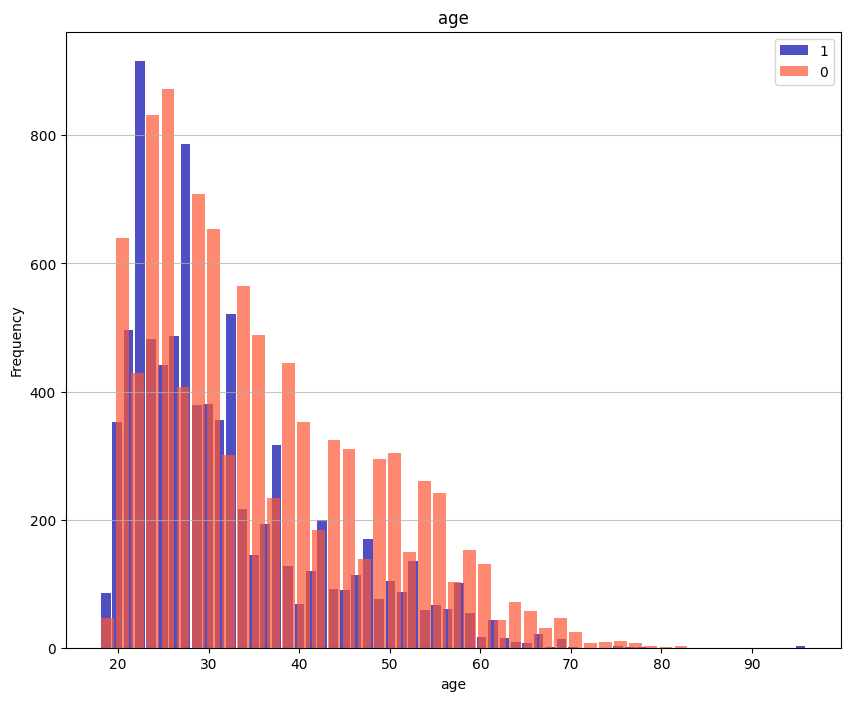

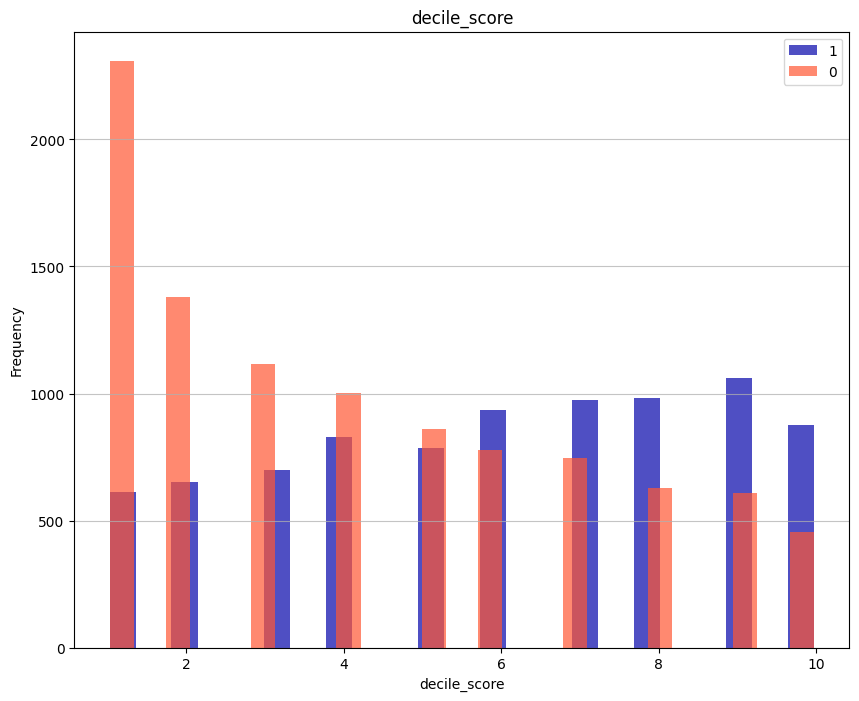

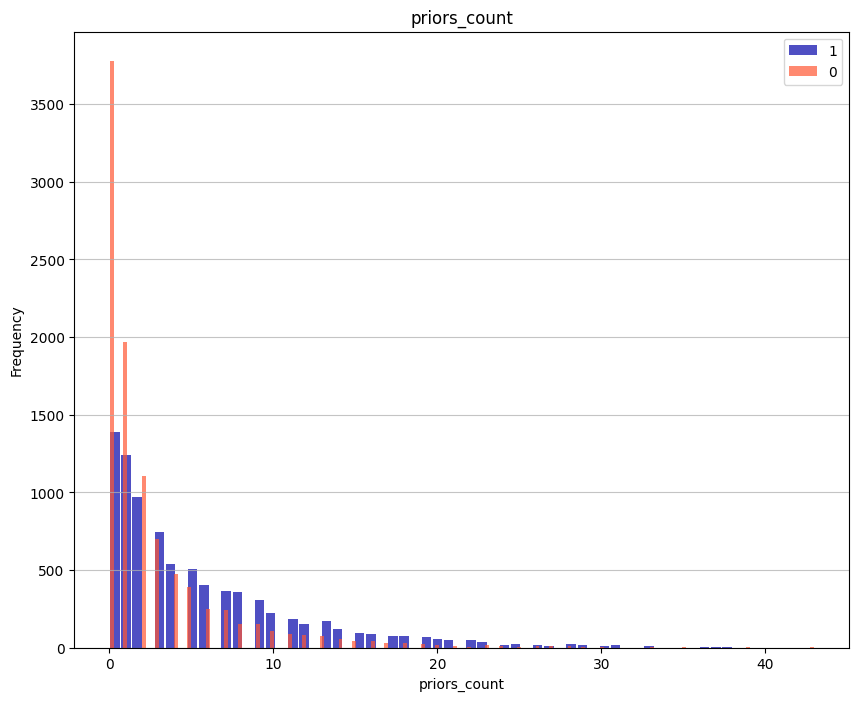

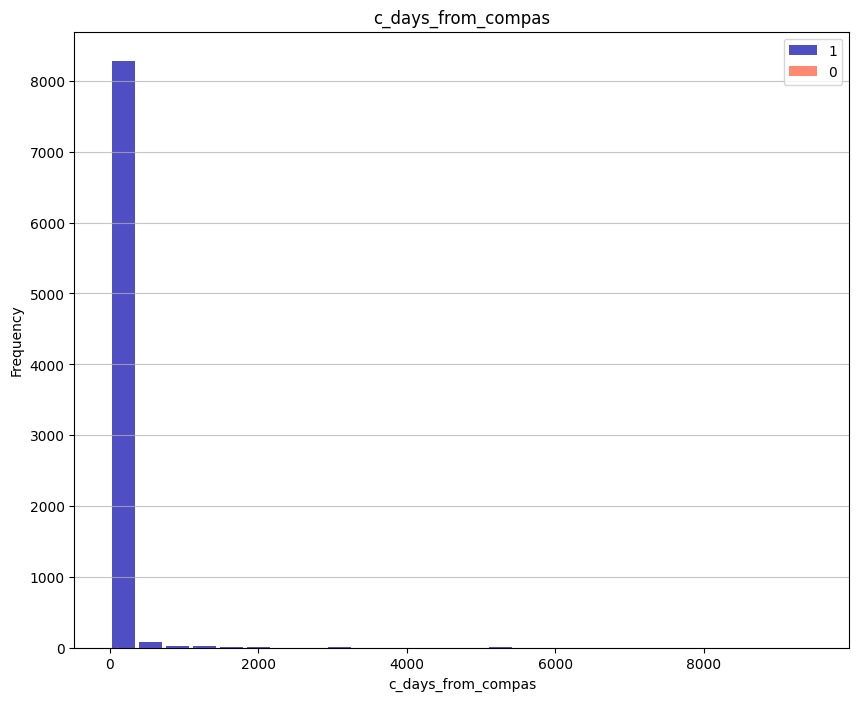

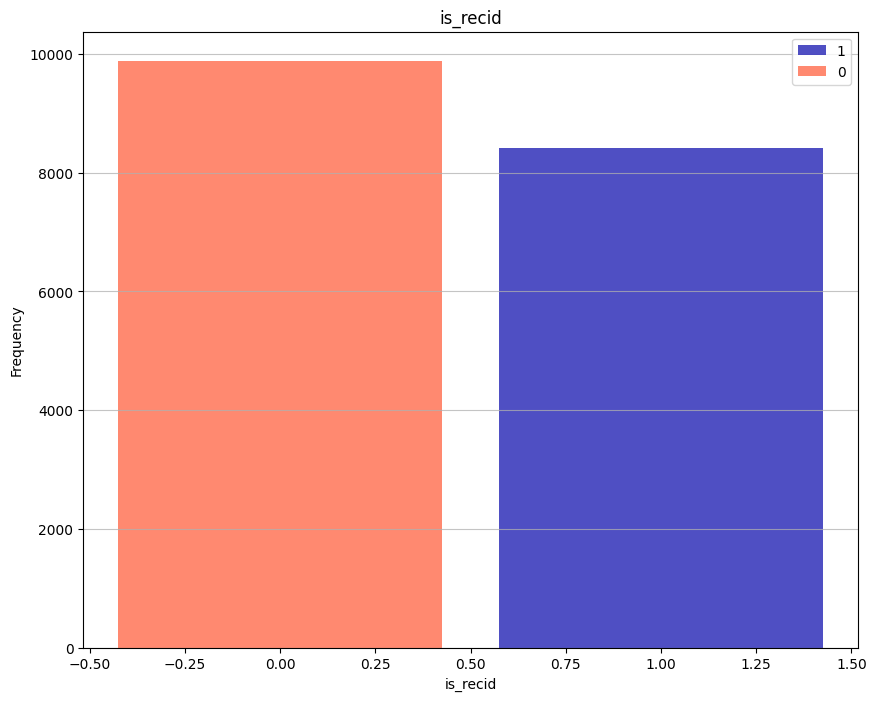

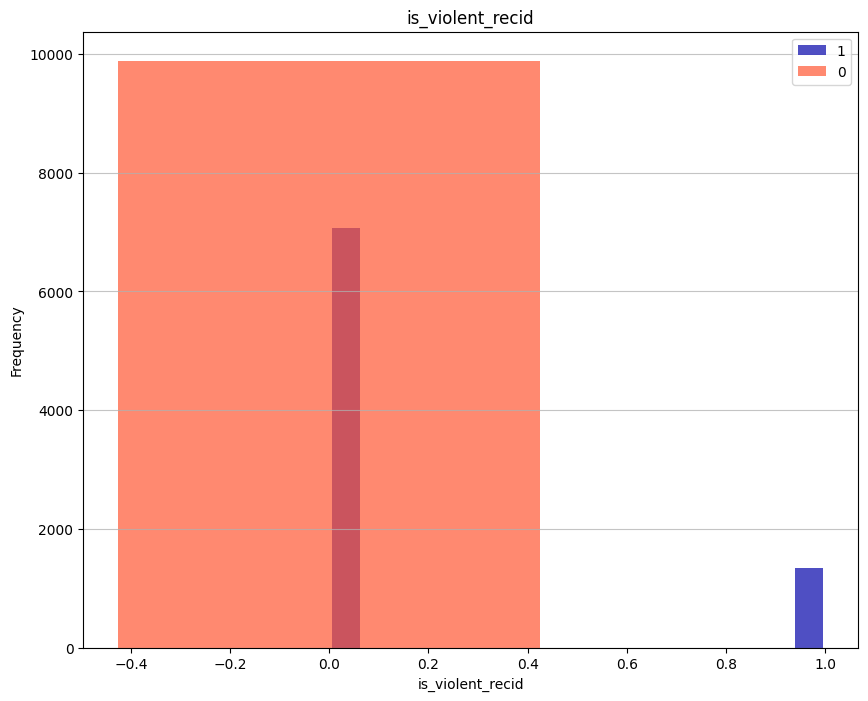

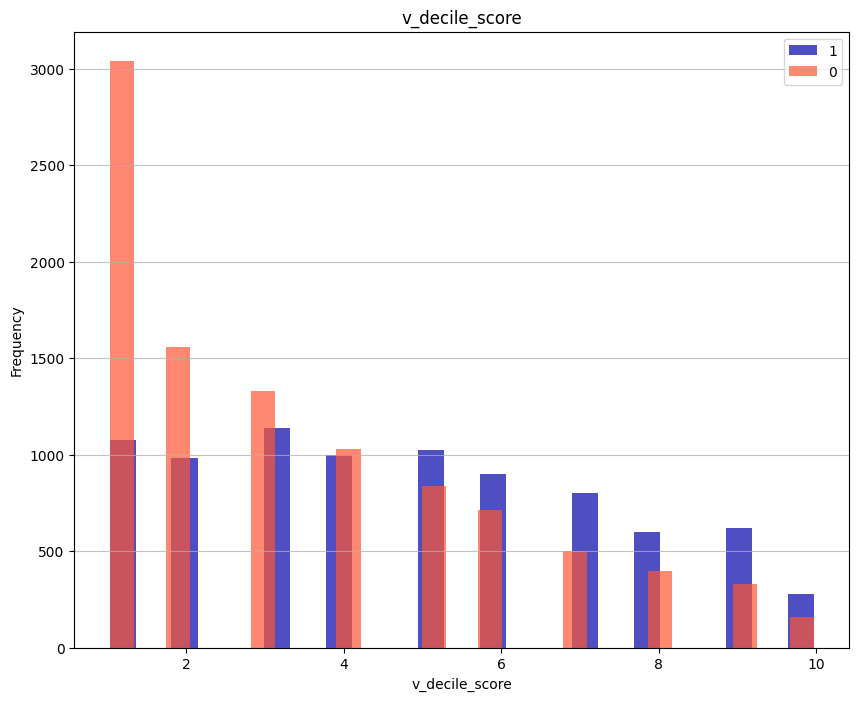

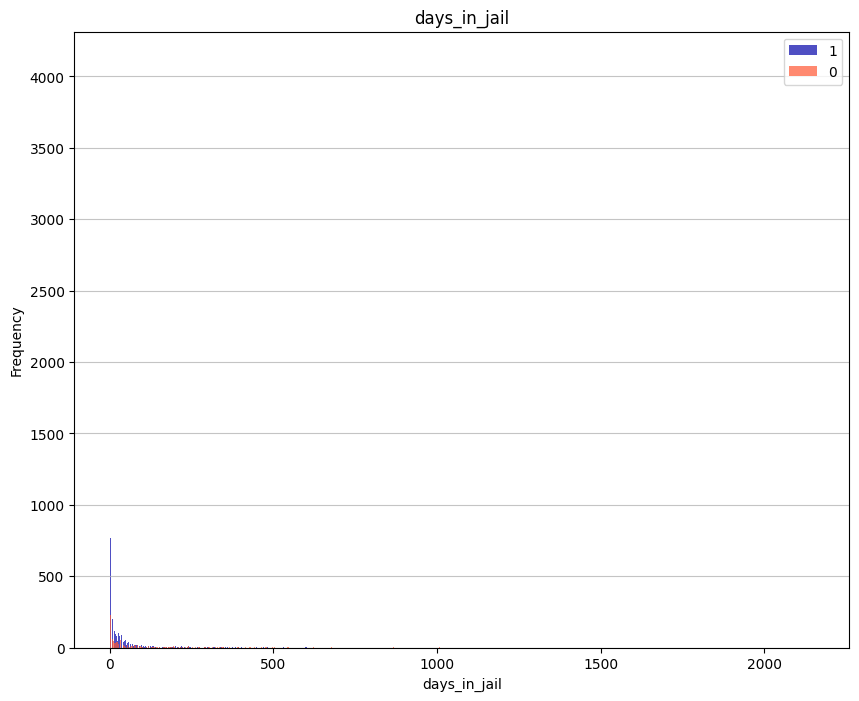

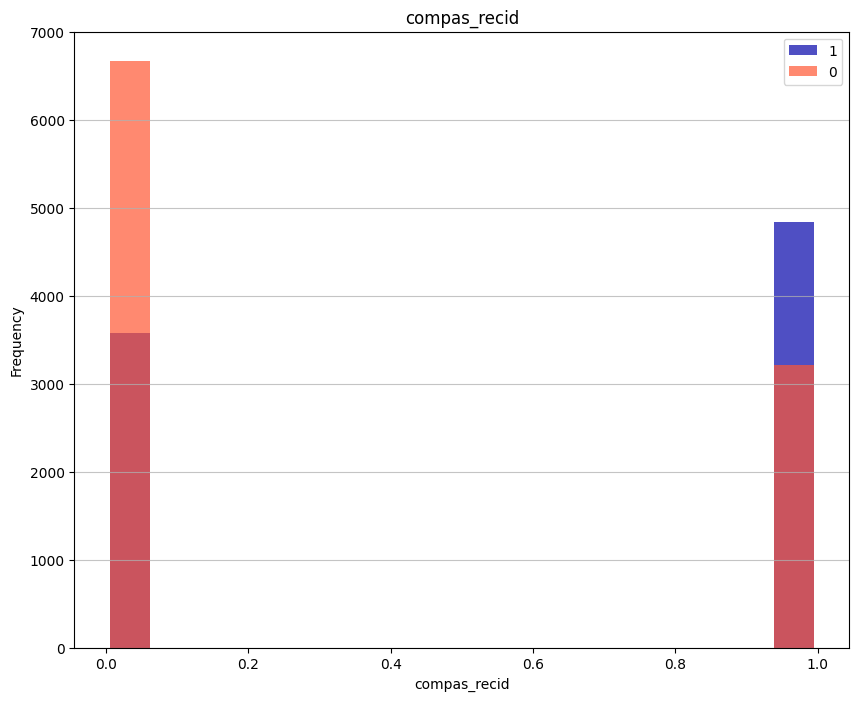

In [32]:
compas_eda.histogram(divide_by_score=True)

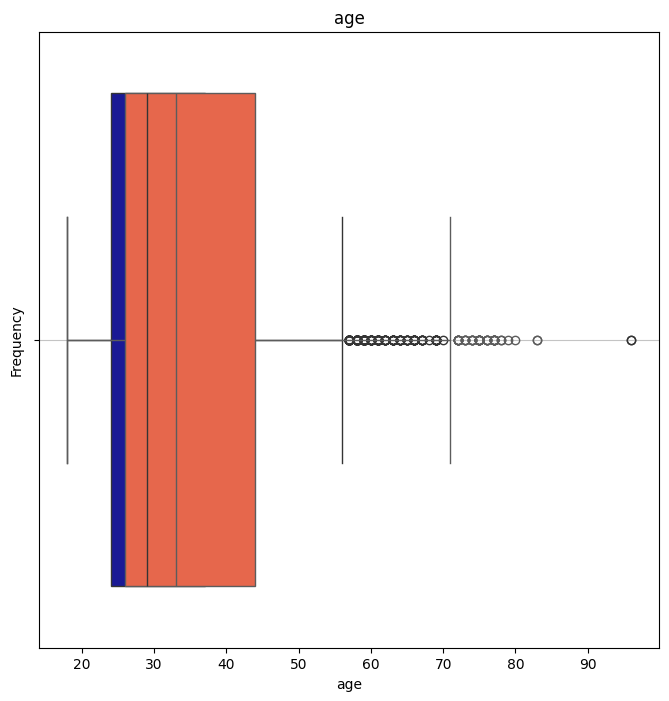

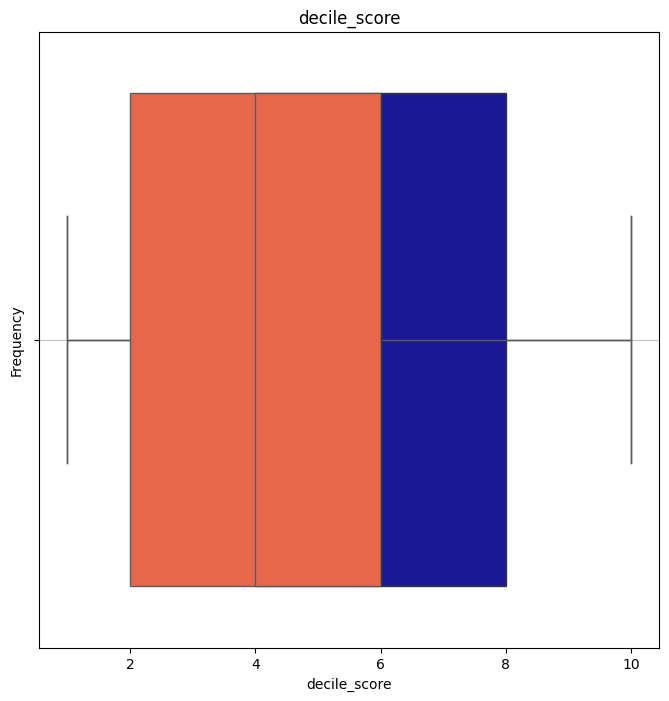

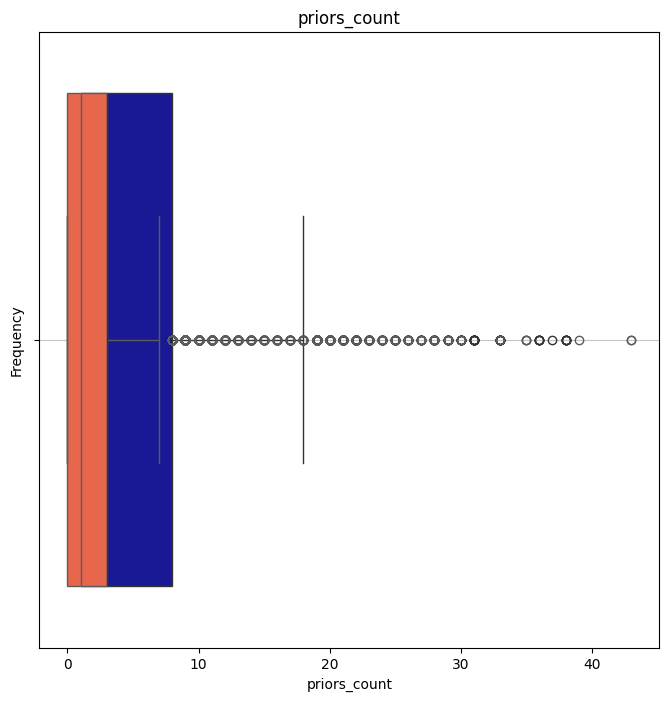

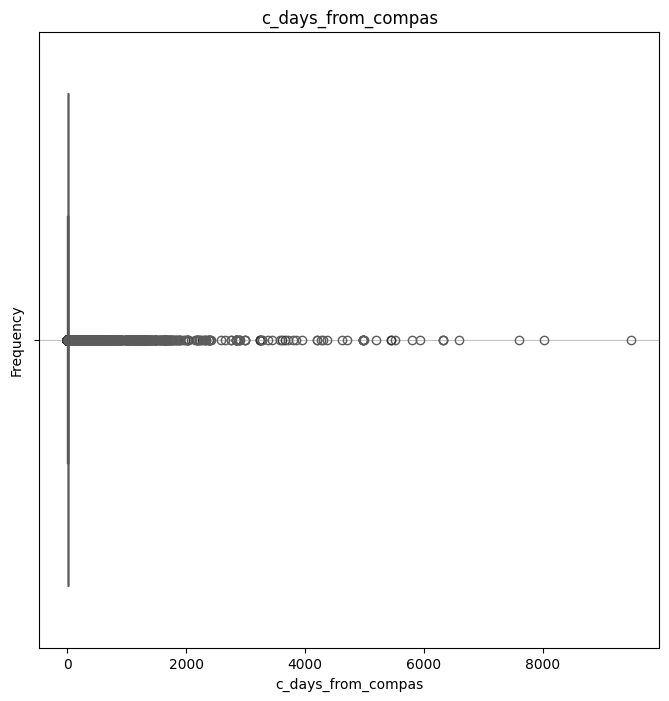

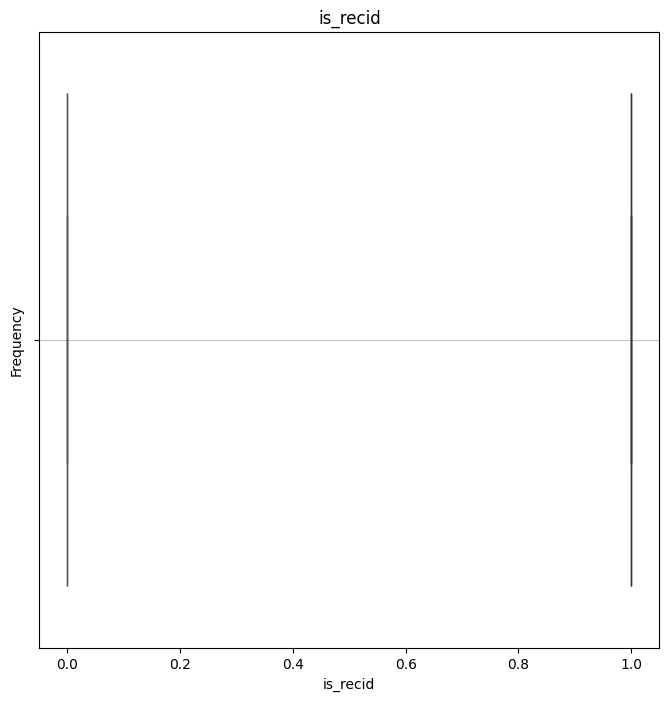

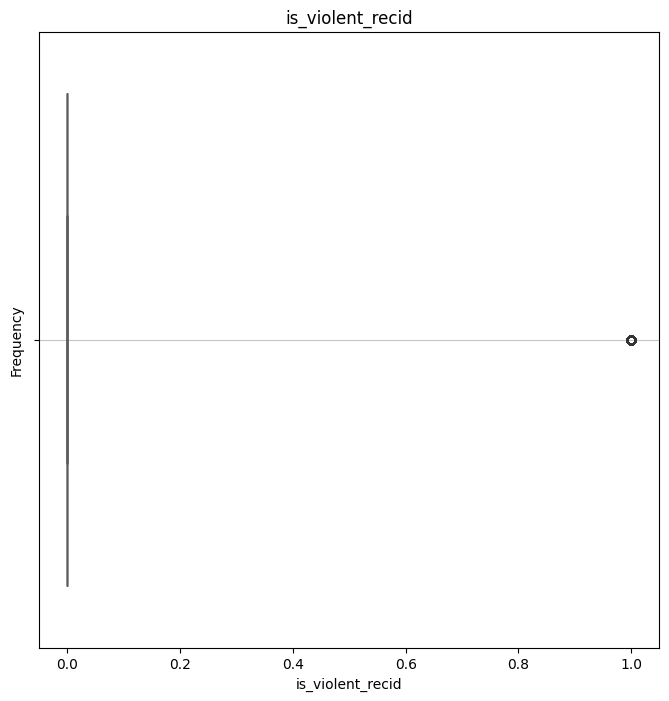

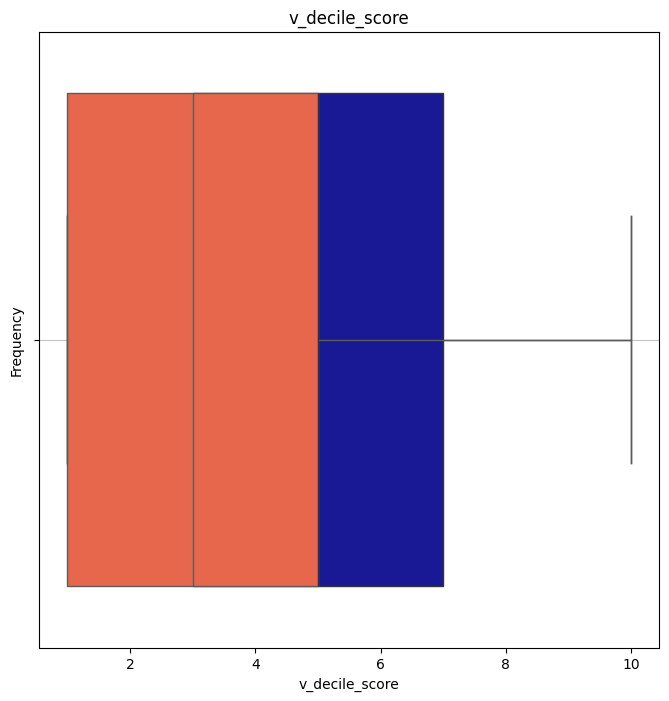

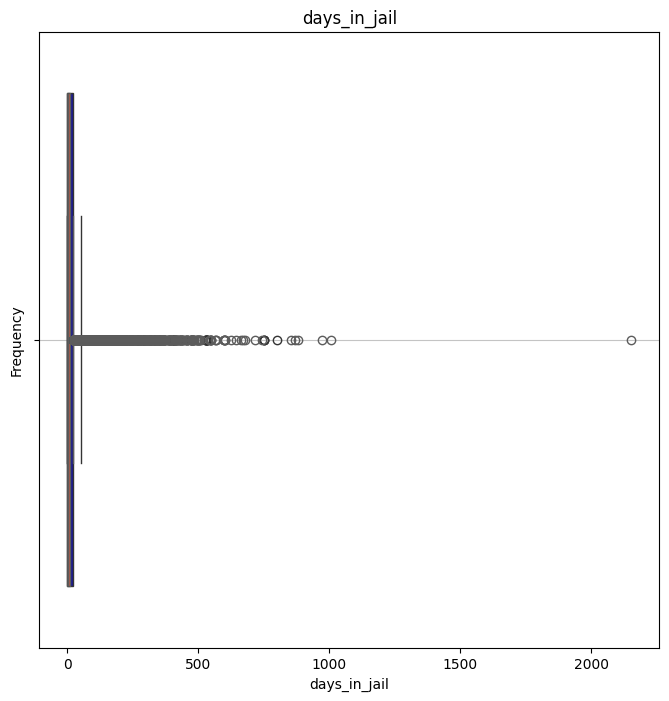

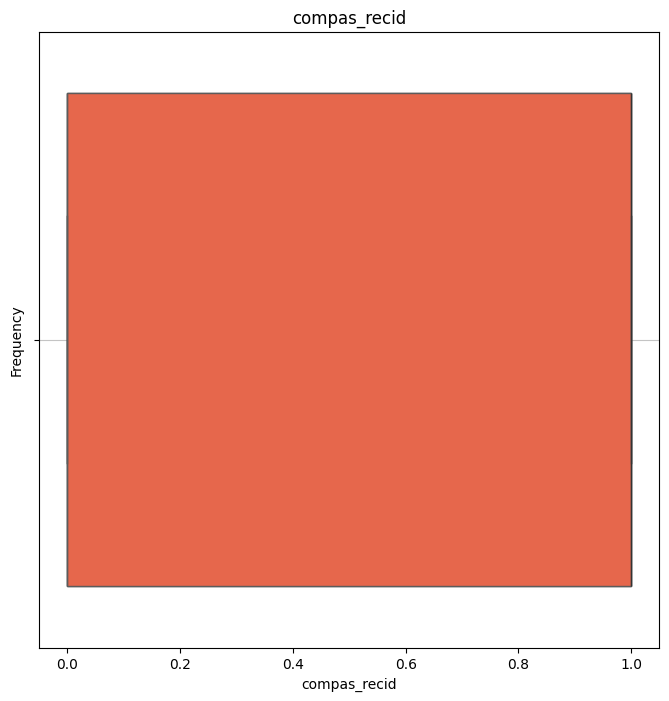

In [33]:
compas_eda.boxplot(divide_by_score=True)

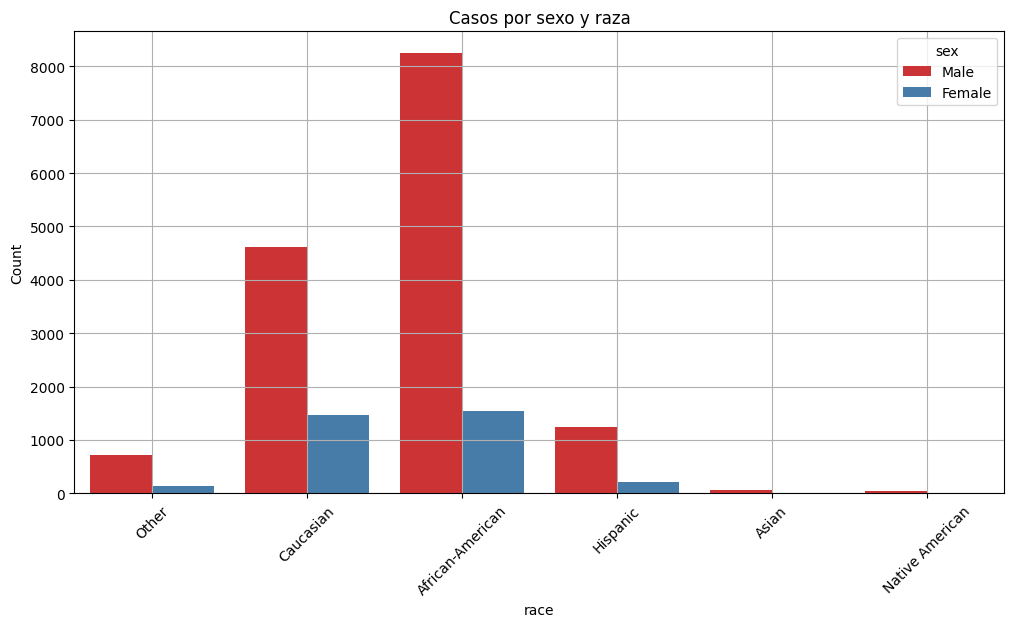

In [34]:
compas_eda.countplot(x = 'race', hue = 'sex' , title = "Casos por sexo y raza")

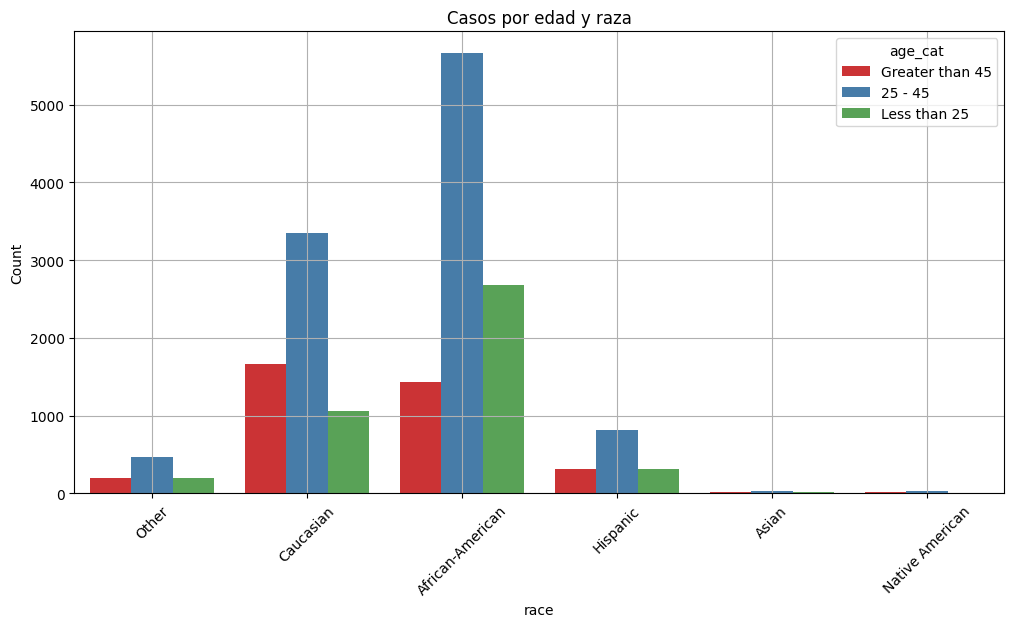

In [35]:
compas_eda.countplot(x = 'race', hue = 'age_cat' , title ="Casos por edad y raza")

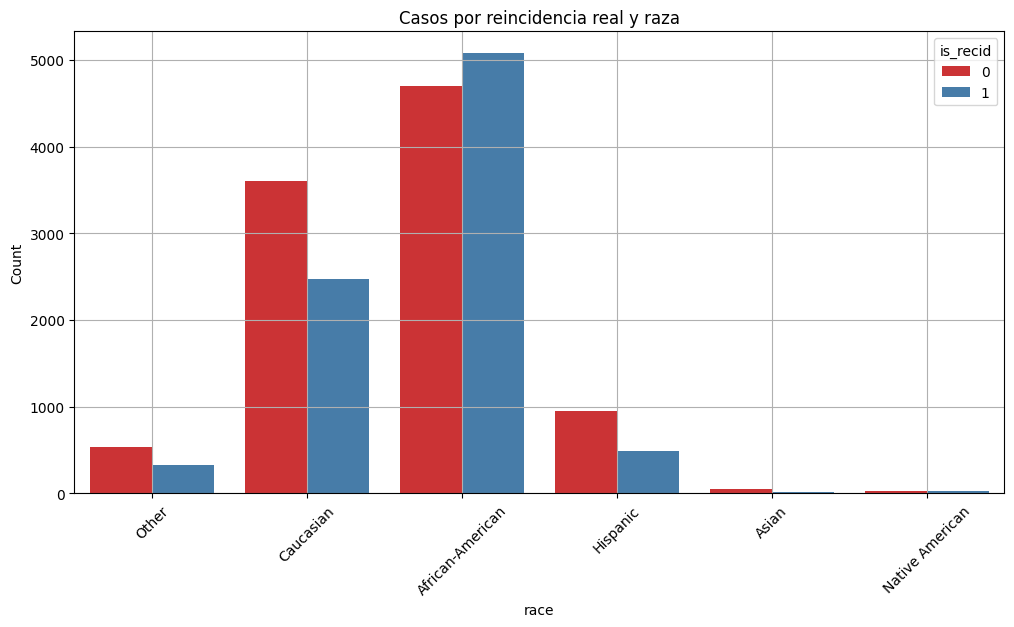

In [36]:
compas_eda.countplot(x = 'race', hue = 'is_recid' , title = "Casos por reincidencia real y raza")

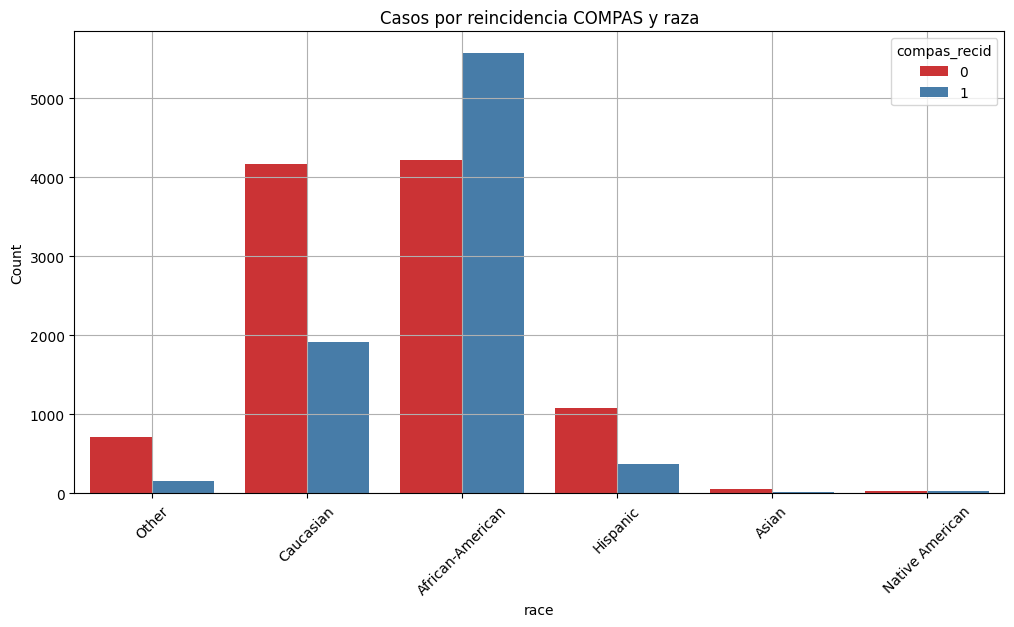

In [37]:
compas_eda.countplot(x = 'race', hue = 'compas_recid' , title = "Casos por reincidencia COMPAS y raza")


**En estas dos últimas gráficas se observa un pequeño sesgo de COMPAS respecto del ground truth de clasificar a los afro-americanos como reincidentes. Mientras que para los caucásicos es a la inversa**

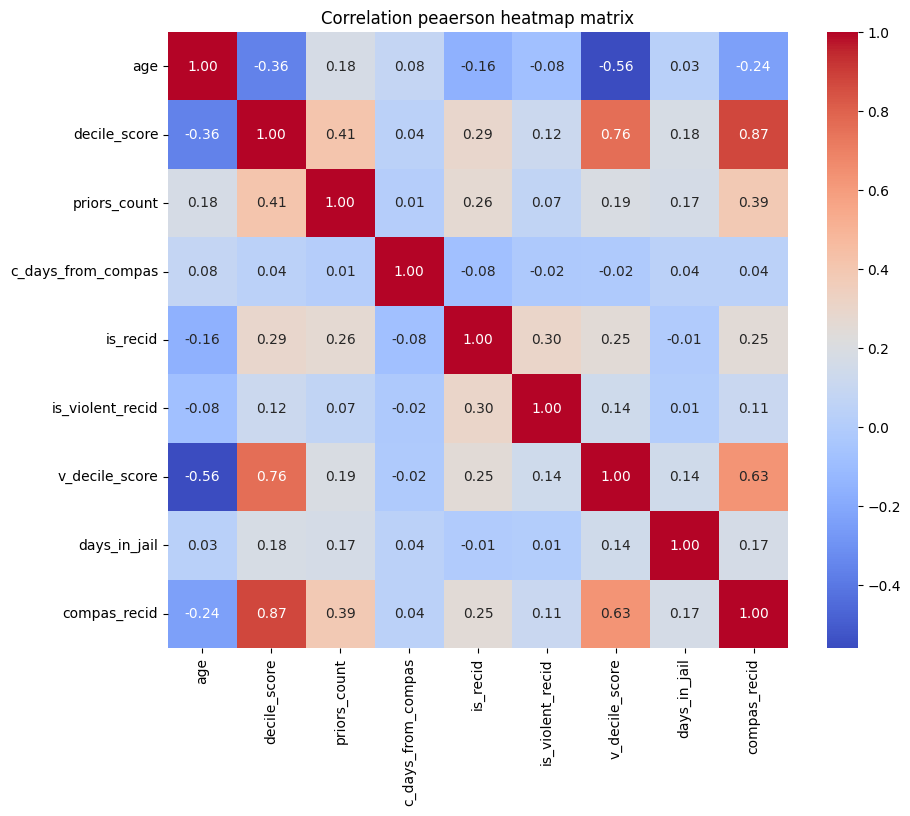

In [38]:
# Matriz ded correlacion
compas_eda.corr_heatmap()

# Modelo comparativo
Lo que se va a hacer ahora es entrenar un modelo prdictivo para comparar con el score (usando el threshold de arriba) que ha otorgado compas de reincidencia.

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

class DataPipeline:
    def __init__(self, df, target_column, test_size=0.2, validation_size=0.2):
        self.df = df
        self.target_column = target_column
        self.test_size = test_size
        self.validation_size = validation_size
        self.train_data = None
        self.test_data = None
        self.validation_data = None
        self.pipeline = None

    def split_data(self):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]

        # Split into train and temp (test + validation)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=self.test_size, random_state=42)

        # Split temp into test and validation
        validation_size_adjusted = self.validation_size / (1 - self.test_size)
        X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=validation_size_adjusted, random_state=42)

        self.train_data = (X_train, y_train)
        self.test_data = (X_test, y_test)
        self.validation_data = (X_validation, y_validation)

    def create_pipeline(self):
        X_train, y_train = self.train_data
        categorical_features = X_train.select_dtypes(include=['object']).columns
        numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

        # Define transformations for numerical features
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Define transformations for categorical features
        categorical_transformers = {}
        for col in categorical_features:
            unique_values = len(X_train[col].unique())
            if unique_values > 10:
                categorical_transformers[col] = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ])
            else:
                categorical_transformers[col] = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal', OrdinalEncoder())
                ])

        # Combine both transformers into a preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                *[(f'cat_{col}', transformer, [col]) for col, transformer in categorical_transformers.items()]
            ]
        )

        # Create the full pipeline with the model
        self.pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', VotingClassifier(estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
            ], voting='soft'))
        ])

    def train_model(self):
        X_train, y_train = self.train_data
        self.pipeline.fit(X_train, y_train)

    def evaluate_model(self):
        X_test, y_test = self.test_data
        X_validation, y_validation = self.validation_data

        test_preds = self.pipeline.predict(X_test)
        validation_preds = self.pipeline.predict(X_validation)

        test_accuracy = accuracy_score(y_test, test_preds)
        validation_accuracy = accuracy_score(y_validation, validation_preds)

        print(f'Test Accuracy: {test_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')

    def predict(self, new_data):
        predictions = self.pipeline.predict(new_data)
        return predictions


In [40]:
# dropeamos el las predicciones del modelo compas basadas en nuestro threshold
data_train = compas_eda.dataframe.drop(columns=["compas_recid"], inplace=False)

In [41]:
compas_eda.dataframe.columns

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'days_in_jail', 'compas_recid'],
      dtype='object')

In [42]:
# Modelo
pipeline = DataPipeline(data_train, 'is_recid')
pipeline.split_data()
pipeline.create_pipeline()
pipeline.train_model()
pipeline.evaluate_model()

Test Accuracy: 0.9059766763848397
Validation Accuracy: 0.8775956284153006


**Una vez entrenado este nuevo modelo, se predice sobre todo conjunto de datos inicial y crea una nueva columna : "custom_recid" para comparar con "is_recid" y "compas_recid"**

In [43]:
data.columns

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'days_in_jail', 'compas_recid'],
      dtype='object')

In [44]:
data["custom_recid"] = pipeline.predict(compas_eda.dataframe)

In [45]:
# Exploramos las predicciones tres modelos : real , compas y custom
eda_custom = CompasEda(data)

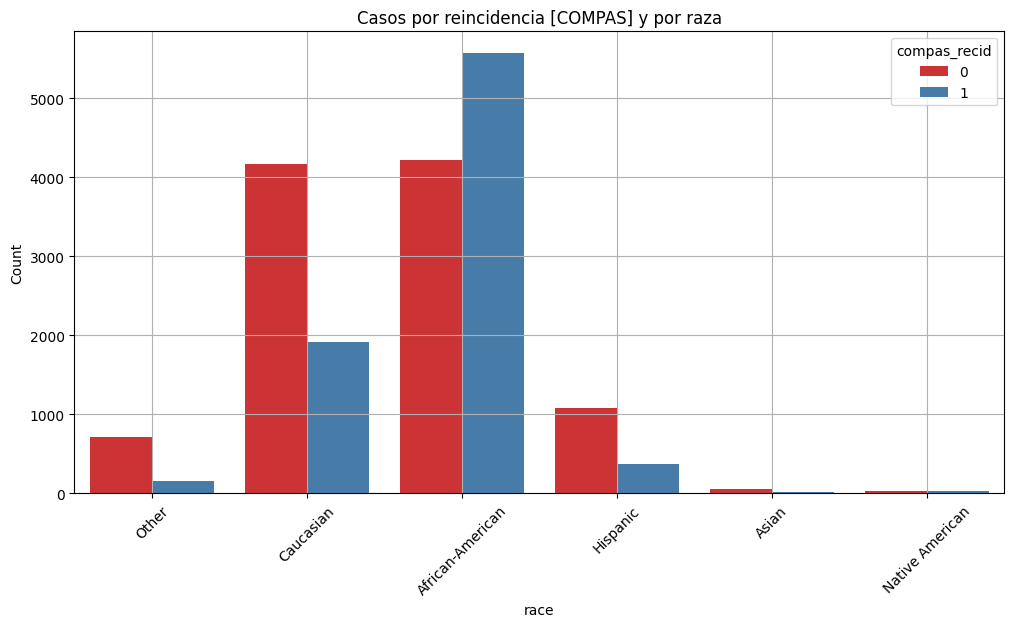

In [46]:
eda_custom.countplot(x = 'race', hue = 'compas_recid' , title = "Casos por reincidencia [COMPAS] y por raza")

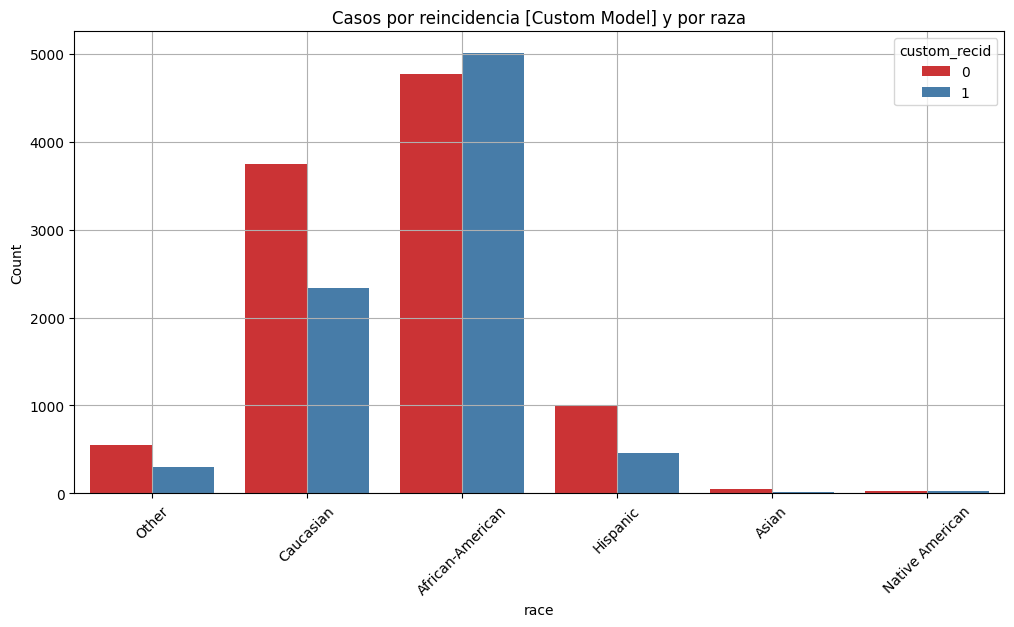

In [47]:
eda_custom.countplot(x = 'race', hue = 'custom_recid' , title = "Casos por reincidencia [Custom Model] y por raza")

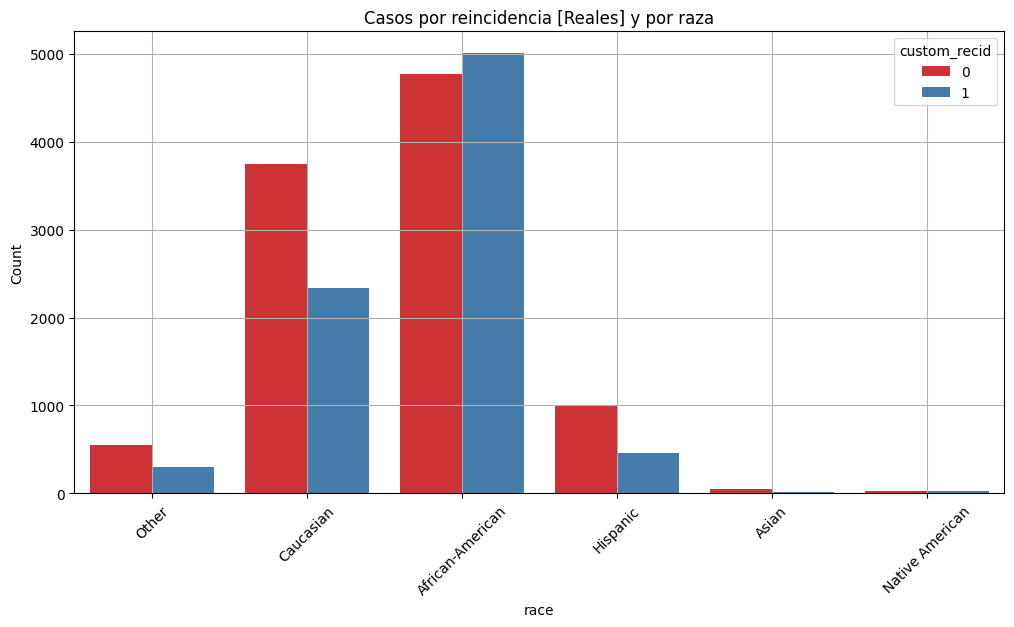

In [48]:
eda_custom.countplot(x = 'race', hue = 'custom_recid' , title = "Casos por reincidencia [Reales] y por raza")

Intentamos identificar algun sesgo en el genero:

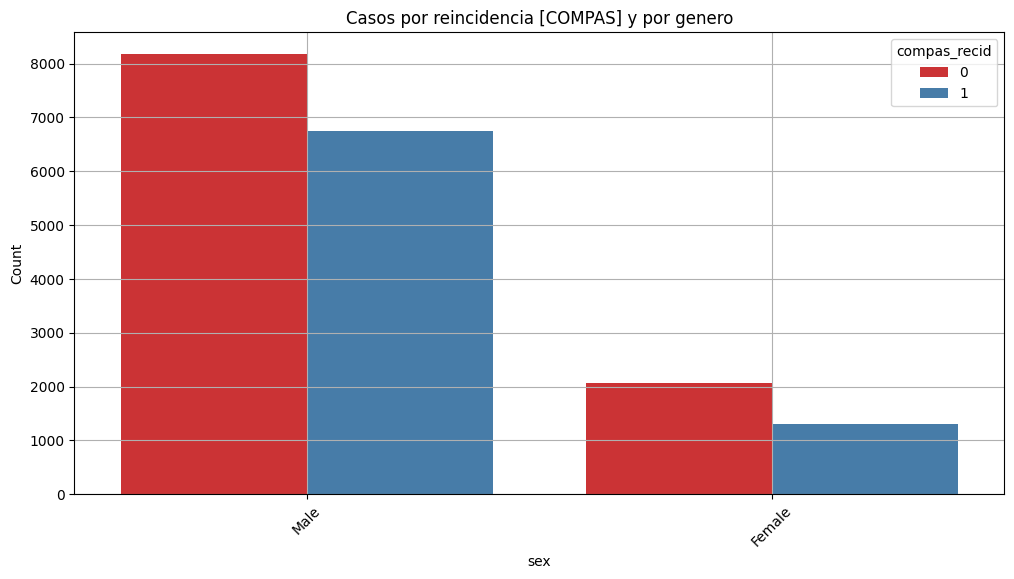

In [49]:
eda_custom.countplot(x = 'sex', hue = 'compas_recid' , title = "Casos por reincidencia [COMPAS] y por genero")

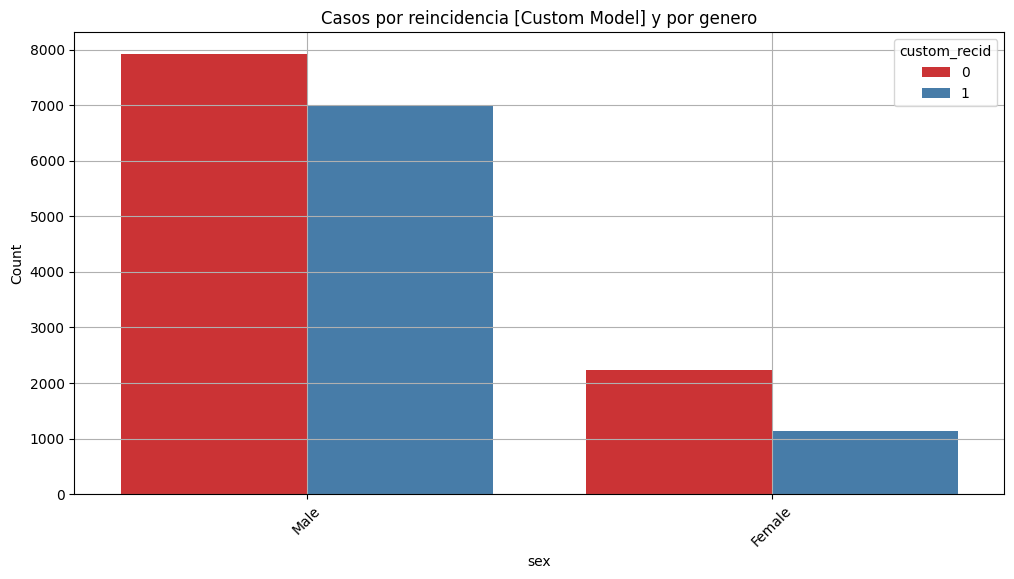

In [50]:
eda_custom.countplot(x = 'sex', hue = 'custom_recid' , title = "Casos por reincidencia [Custom Model] y por genero")

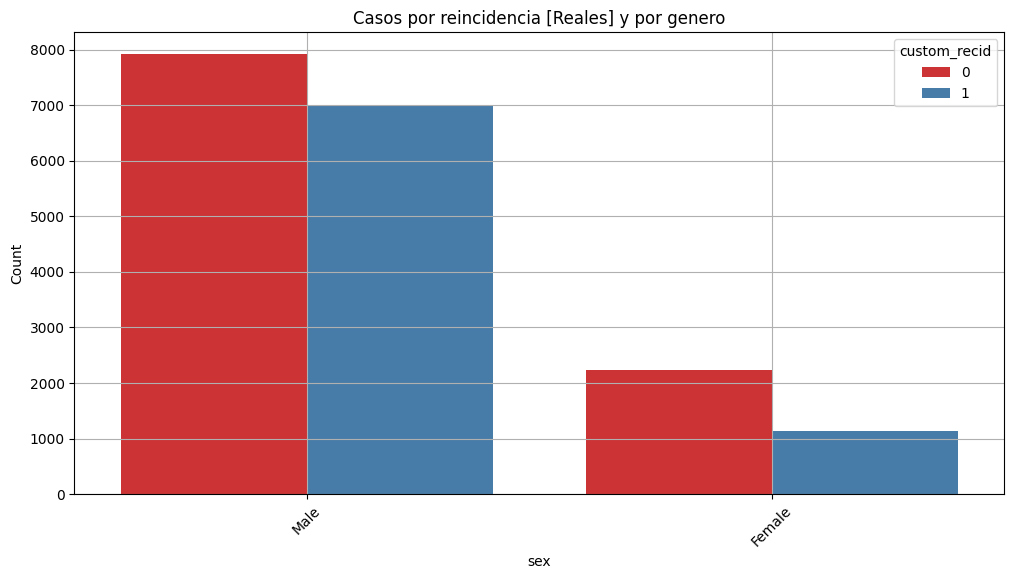

In [51]:
eda_custom.countplot(x = 'sex', hue = 'custom_recid' , title = "Casos por reincidencia [Reales] y por genero")

**A simple vista se observa claramente el sesgo en la raza afroamericana del modelo de COMPAS.**

Aun así, vamos a calcular ciertas métricas para el modelo de COMPAS y el modelo personalizado, como la matriz de confusión.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import seaborn as sns


class MetricsByCategory:
    def __init__(self, df, predictions_column, true_labels_column, category_column):
        self.df = df
        self.predictions_column = predictions_column
        self.true_labels_column = true_labels_column
        self.category_column = category_column

    def compute_confusion_matrix(self, category_value):
        data_subset = self.df[self.df[self.category_column] == category_value]
        y_true = data_subset[self.true_labels_column]
        y_pred = data_subset[self.predictions_column]

        cm = confusion_matrix(y_true, y_pred)
        support = len(y_true)
        return cm, support

    def plot_confusion_matrix(self, cm, category_value, support):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {category_value} (support: {support})')
        plt.show()

    def compute_roc_curve(self, category_value):
        data_subset = self.df[self.df[self.category_column] == category_value]
        y_true = data_subset[self.true_labels_column]
        y_score = data_subset[self.predictions_column]  # Assuming predictions are probabilities

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

    def plot_roc_curve(self, fpr, tpr, roc_auc, category_value):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {category_value}')
        plt.legend(loc="lower right")
        plt.show()

    def compute_metrics(self, category_value):
        data_subset = self.df[self.df[self.category_column] == category_value]
        y_true = data_subset[self.true_labels_column]
        y_pred = data_subset[self.predictions_column]

        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        return precision, recall, f1, support

    def compute_error_rates(self, cm):
        tn, fp, fn, tp = cm.ravel()
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        return fp_rate, fn_rate

    def analyze_by_category(self):
        categories = self.df[self.category_column].unique()
        metrics_list = []
        for category in categories:
            print(f'Category: {category}')
            cm, support = self.compute_confusion_matrix(category)
            self.plot_confusion_matrix(cm, category, support)

            fpr, tpr, roc_auc = self.compute_roc_curve(category)
            self.plot_roc_curve(fpr, tpr, roc_auc, category)

            precision, recall, f1, support = self.compute_metrics(category)
            fp_rate, fn_rate = self.compute_error_rates(cm)
            metrics_list.append({
                'Category': category,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'False Positive Rate': fp_rate,
                'False Negative Rate': fn_rate
            })

        metrics_df = pd.DataFrame(metrics_list)
        return metrics_df


def plot_disparities(metrics_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Category", y='False Positive Rate', data=metrics_df, palette='Blues_d')
    plt.title('FP por categoria')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Category", y='False Negative Rate', data=metrics_df, palette='Reds_d')
    plt.title('FN por categoria')
    plt.show()


In [53]:
data.columns

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'days_in_jail', 'compas_recid', 'custom_recid'],
      dtype='object')

Category: Other


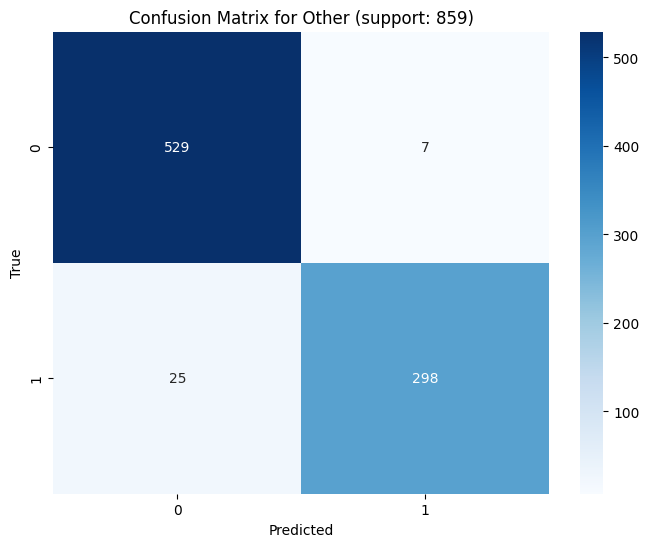

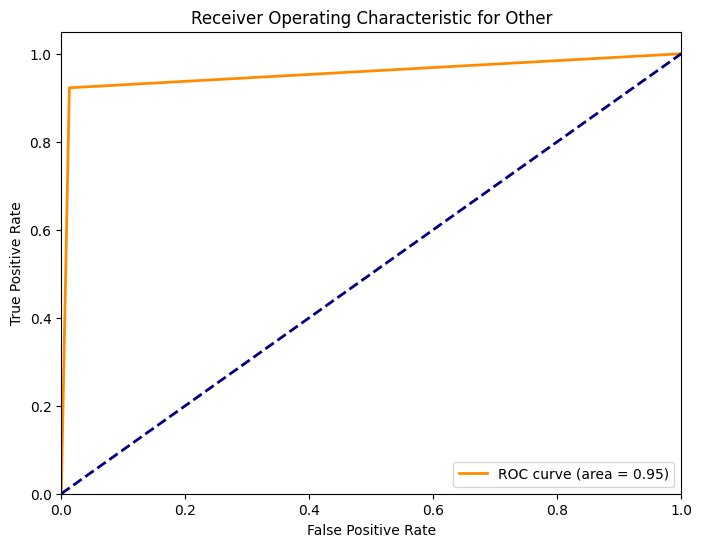

Category: Caucasian


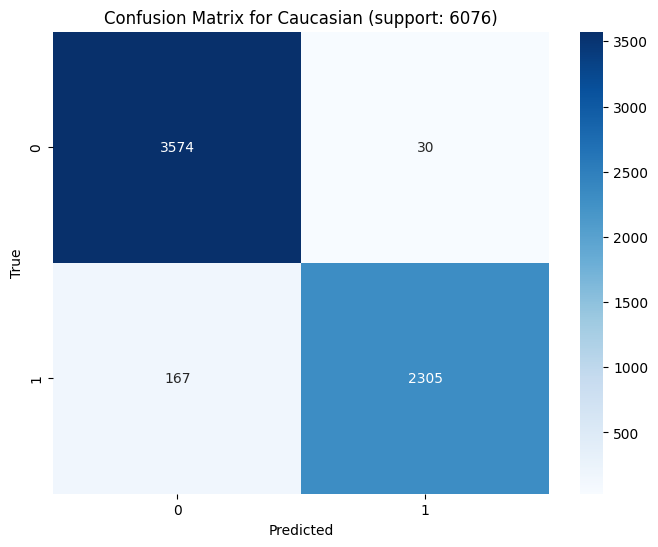

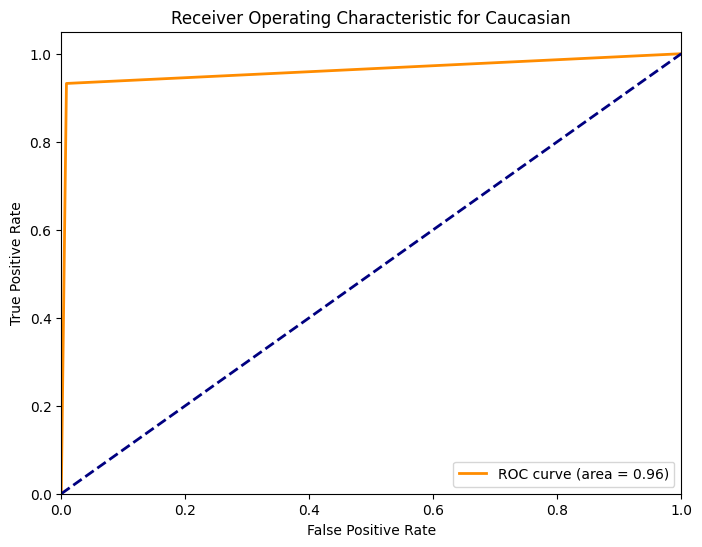

Category: African-American


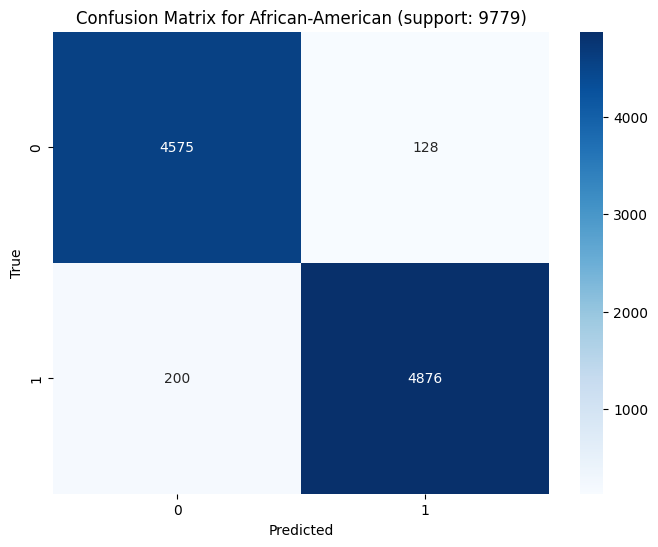

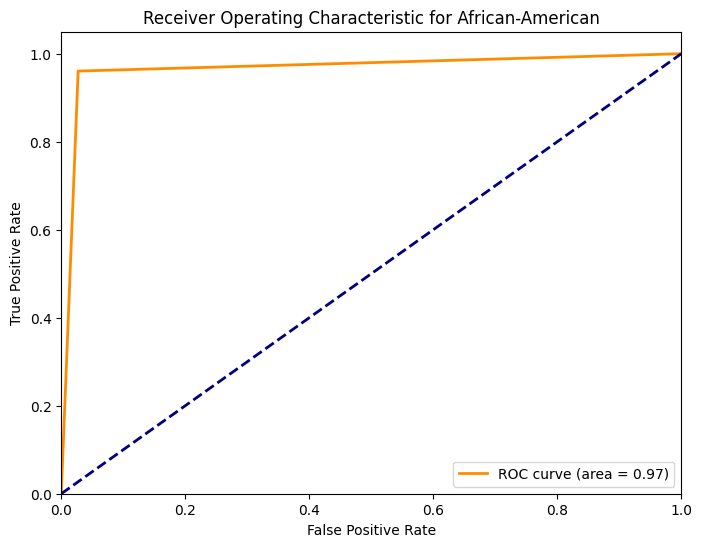

Category: Hispanic


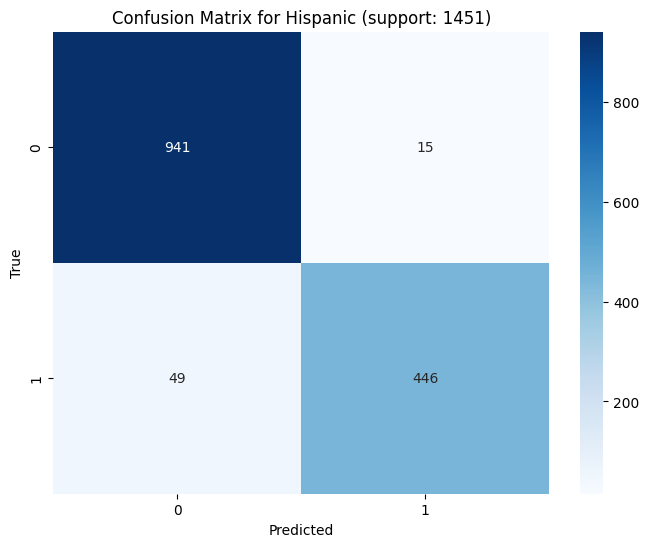

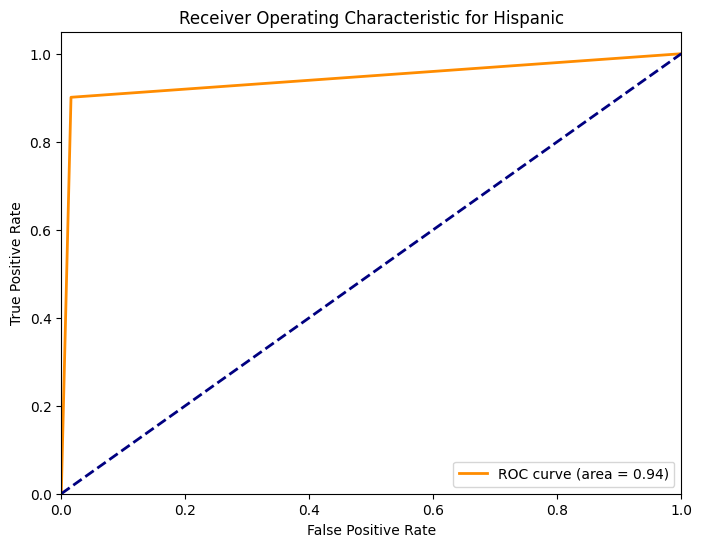

Category: Asian


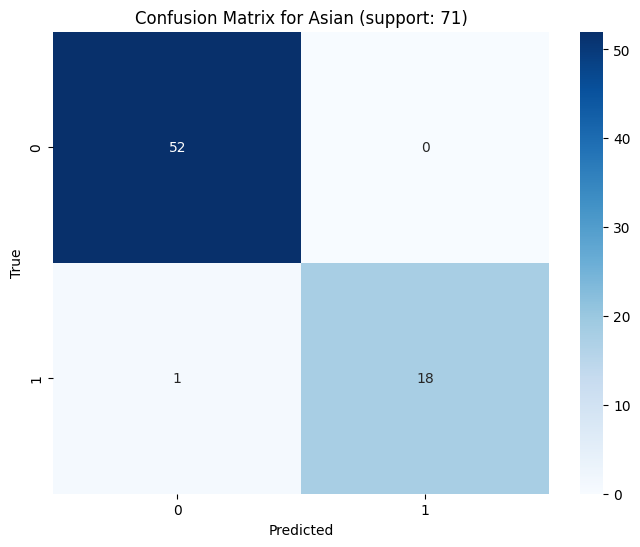

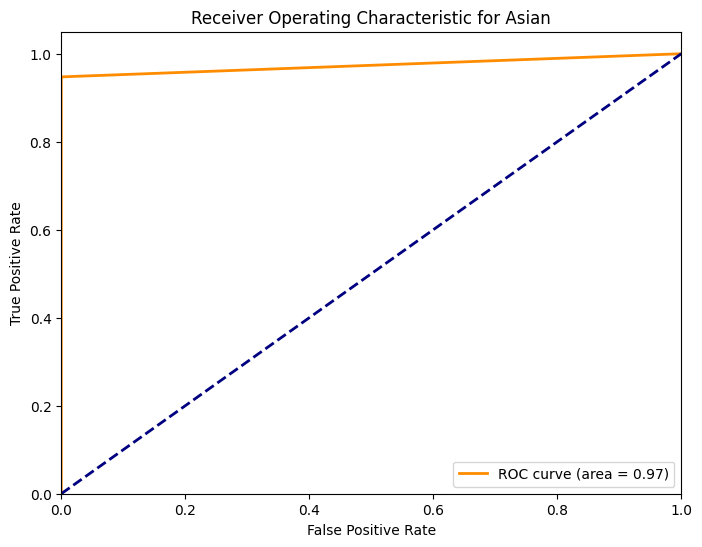

Category: Native American


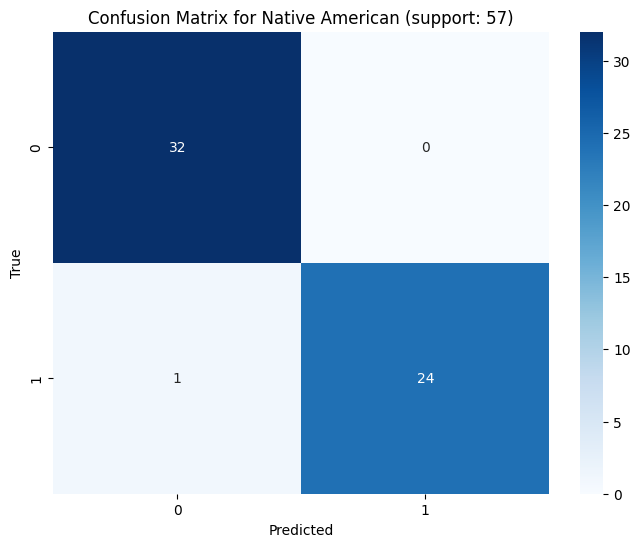

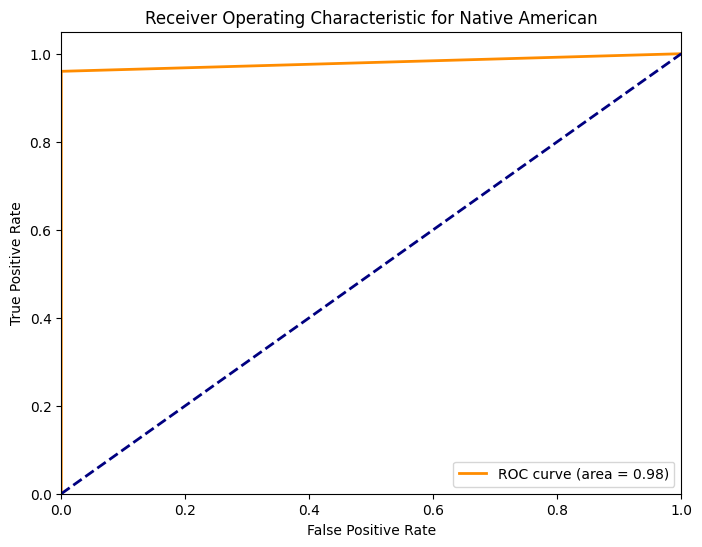

           Category  Precision    Recall  F1-Score  False Positive Rate  \
0             Other   0.977049  0.922601  0.949045             0.013060   
1         Caucasian   0.987152  0.932443  0.959018             0.008324   
2  African-American   0.974420  0.960599  0.967460             0.027217   
3          Hispanic   0.967462  0.901010  0.933054             0.015690   
4             Asian   1.000000  0.947368  0.972973             0.000000   
5   Native American   1.000000  0.960000  0.979592             0.000000   

   False Negative Rate  
0             0.077399  
1             0.067557  
2             0.039401  
3             0.098990  
4             0.052632  
5             0.040000  


In [54]:
metrics =  MetricsByCategory(data, 'custom_recid', 'is_recid', 'race')
metrics_df = metrics.analyze_by_category()
print(metrics_df)

<ipython-input-52-c10536269475>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Positive Rate', data=metrics_df, palette='Blues_d')


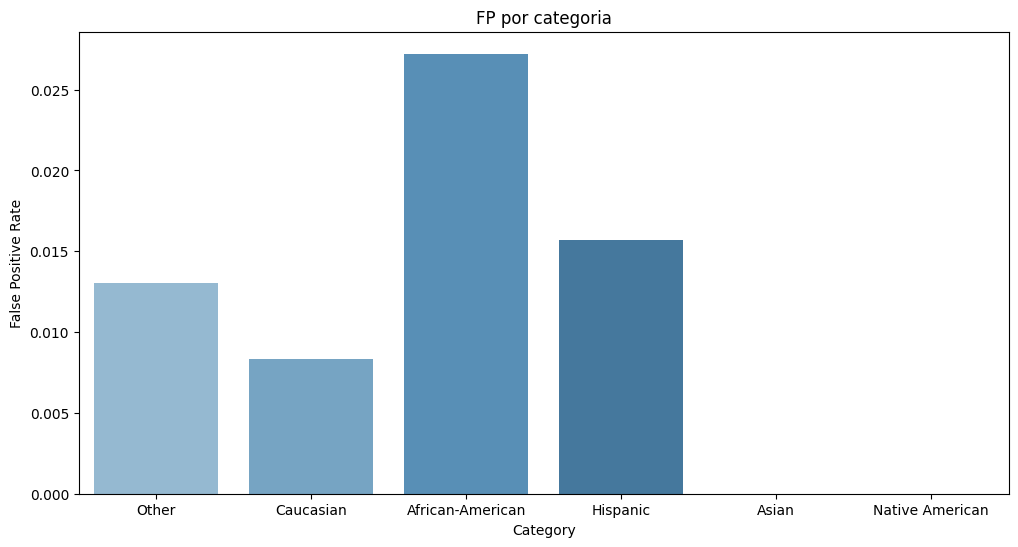

<ipython-input-52-c10536269475>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Negative Rate', data=metrics_df, palette='Reds_d')


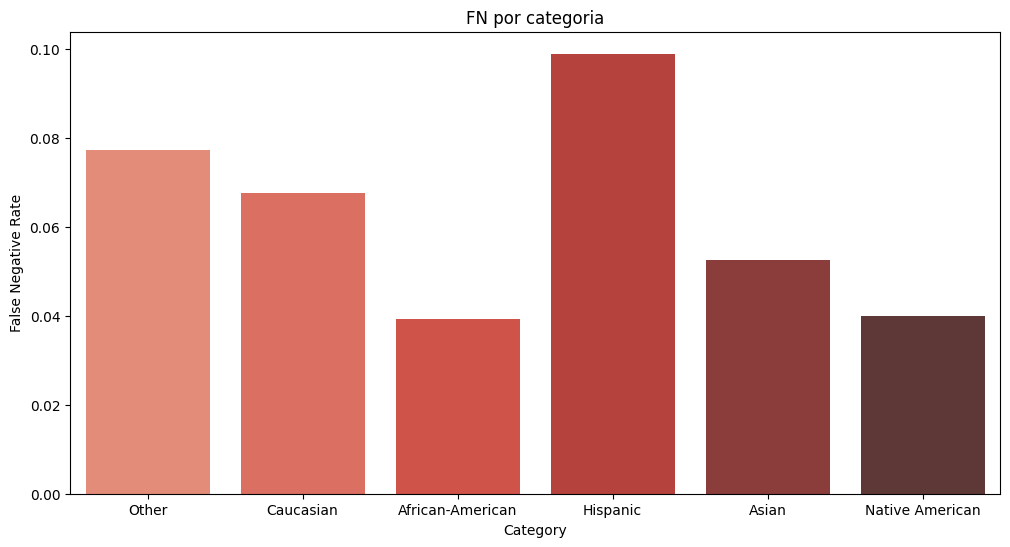

In [55]:
plot_disparities(metrics_df)

Category: Other


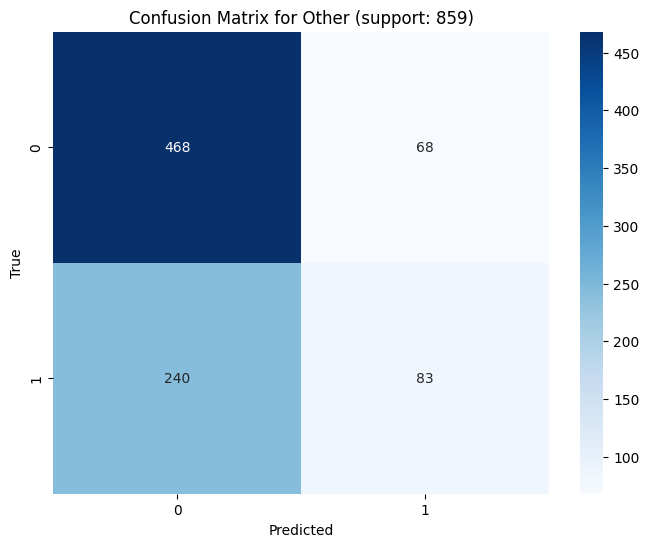

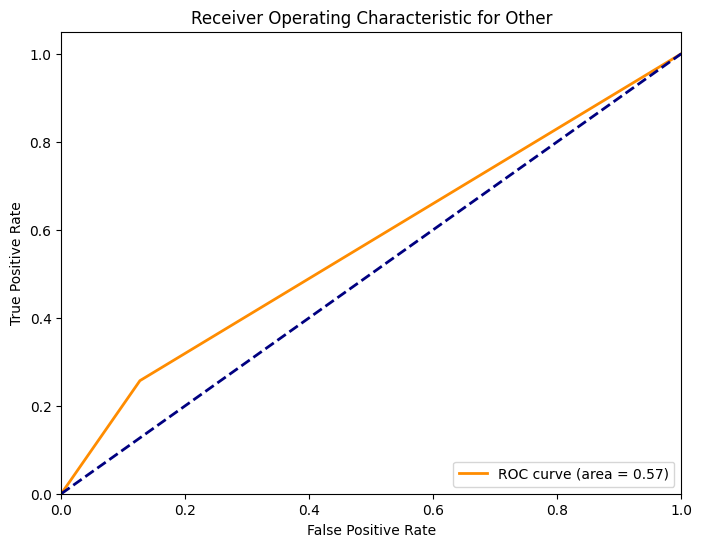

Category: Caucasian


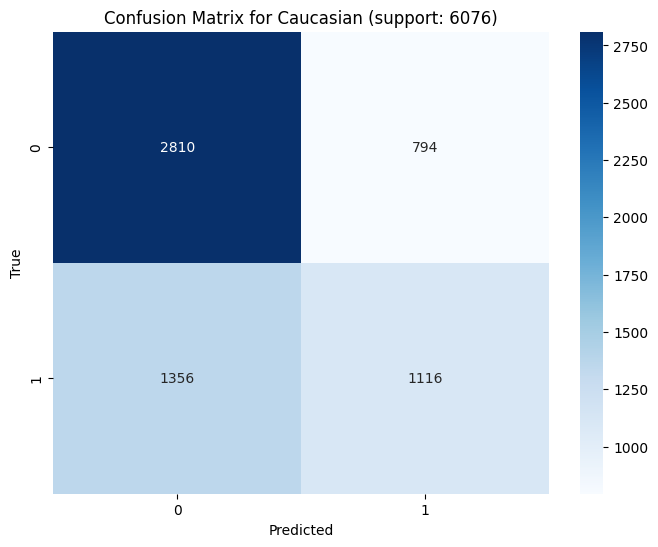

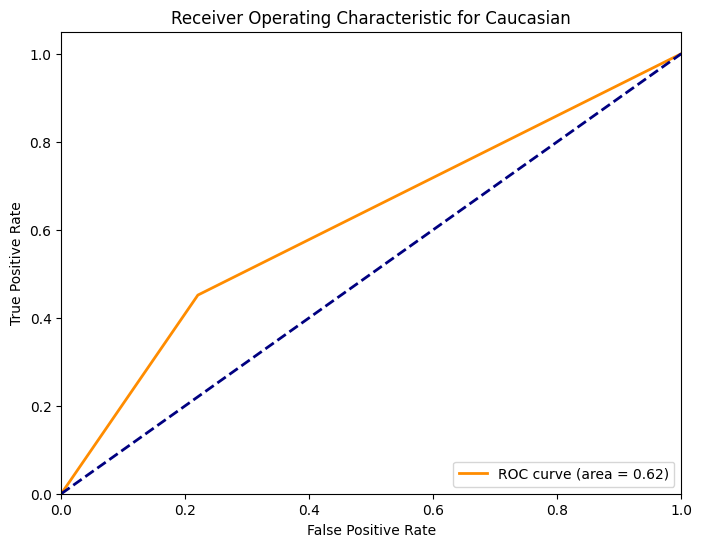

Category: African-American


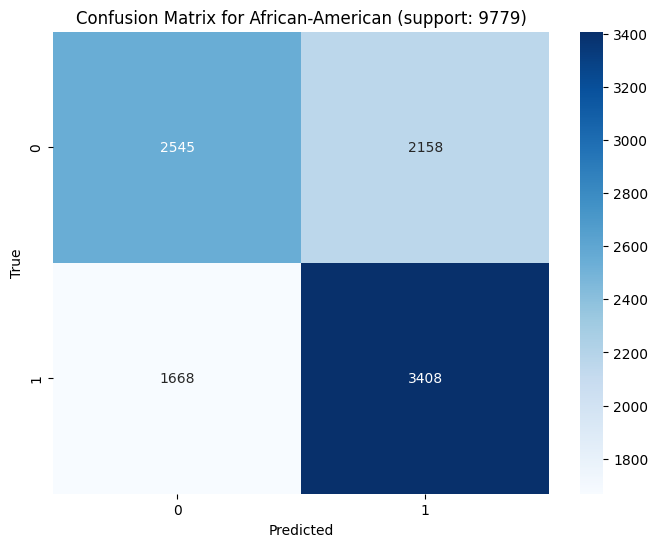

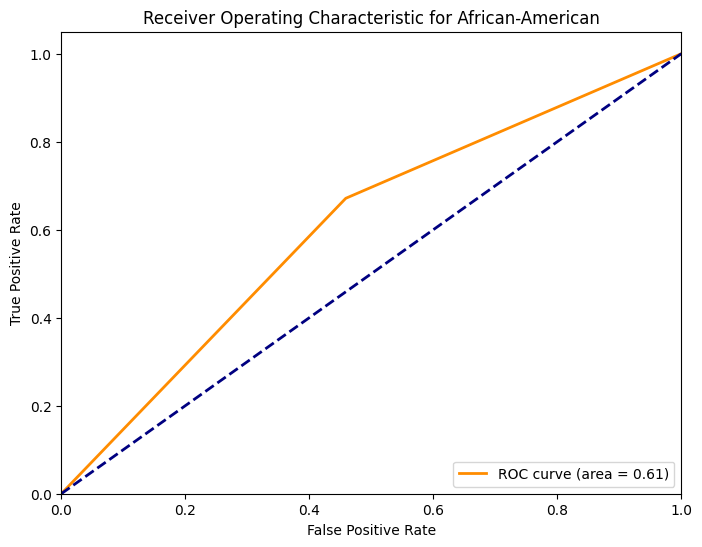

Category: Hispanic


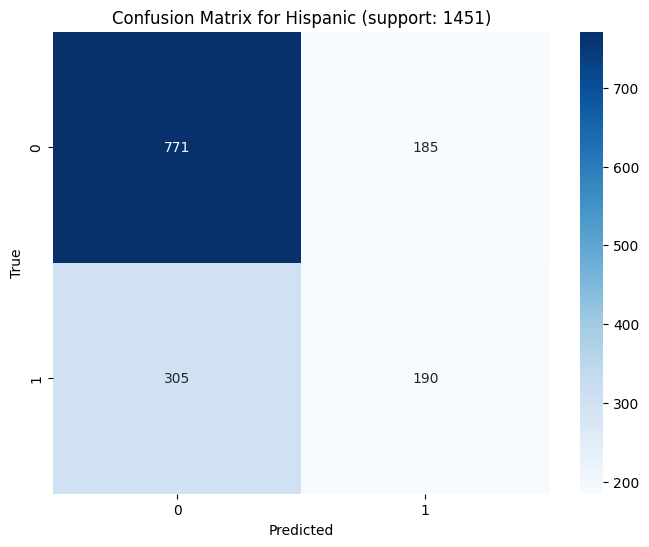

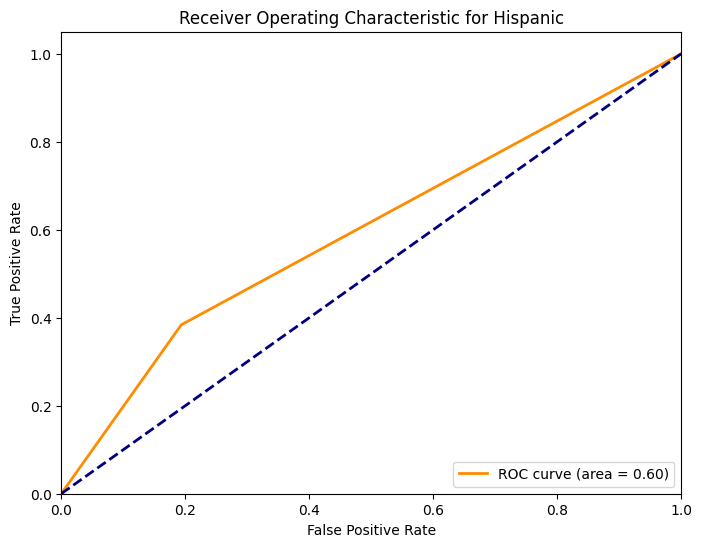

Category: Asian


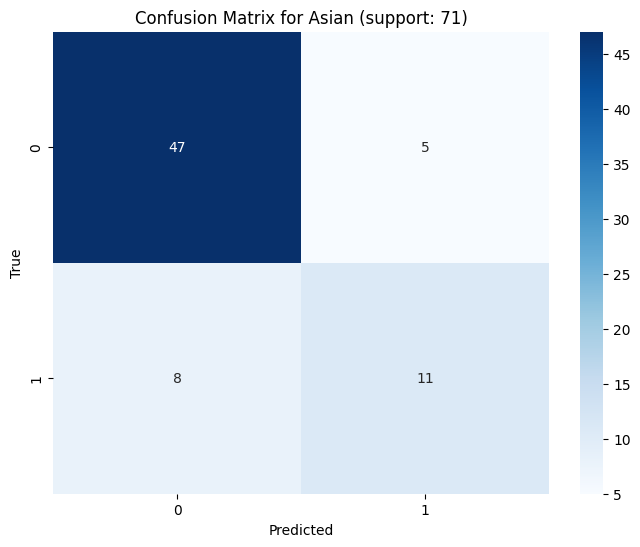

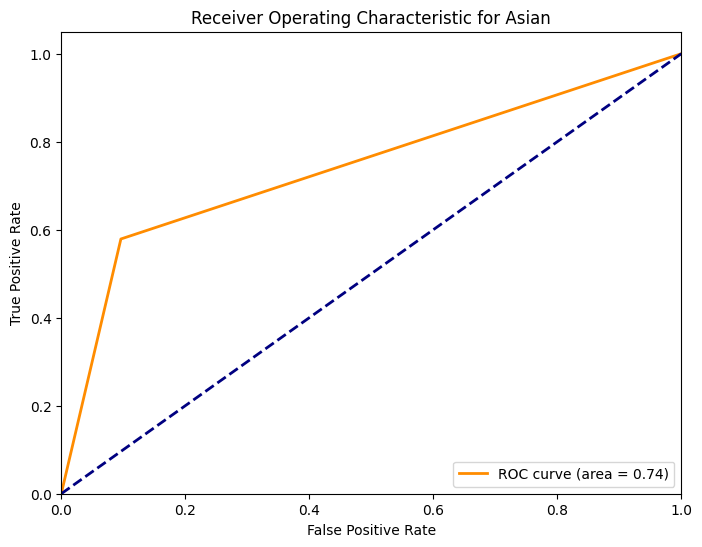

Category: Native American


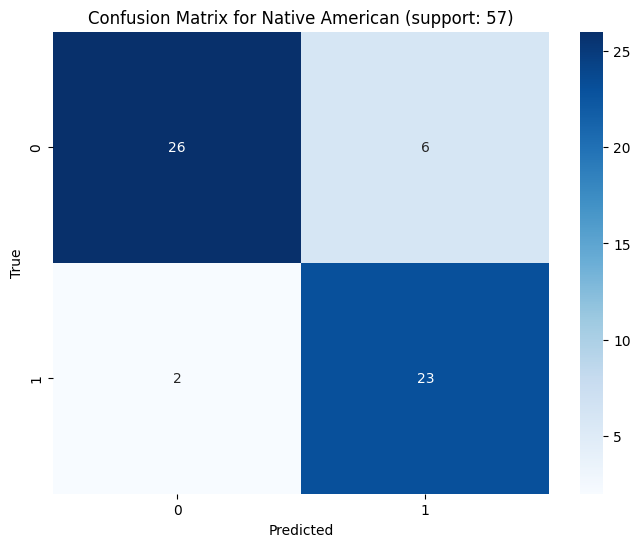

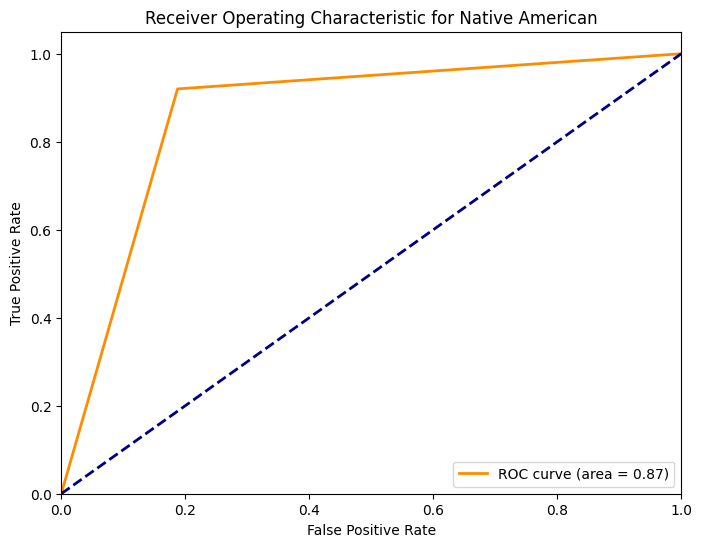

           Category  Precision    Recall  F1-Score  False Positive Rate  \
0             Other   0.549669  0.256966  0.350211             0.126866   
1         Caucasian   0.584293  0.451456  0.509356             0.220311   
2  African-American   0.612289  0.671395  0.640481             0.458856   
3          Hispanic   0.506667  0.383838  0.436782             0.193515   
4             Asian   0.687500  0.578947  0.628571             0.096154   
5   Native American   0.793103  0.920000  0.851852             0.187500   

   False Negative Rate  
0             0.743034  
1             0.548544  
2             0.328605  
3             0.616162  
4             0.421053  
5             0.080000  


In [56]:
metrics =  MetricsByCategory(data, 'compas_recid', 'is_recid', 'race')
metrics_df = metrics.analyze_by_category()
print(metrics_df)

<ipython-input-52-c10536269475>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Positive Rate', data=metrics_df, palette='Blues_d')


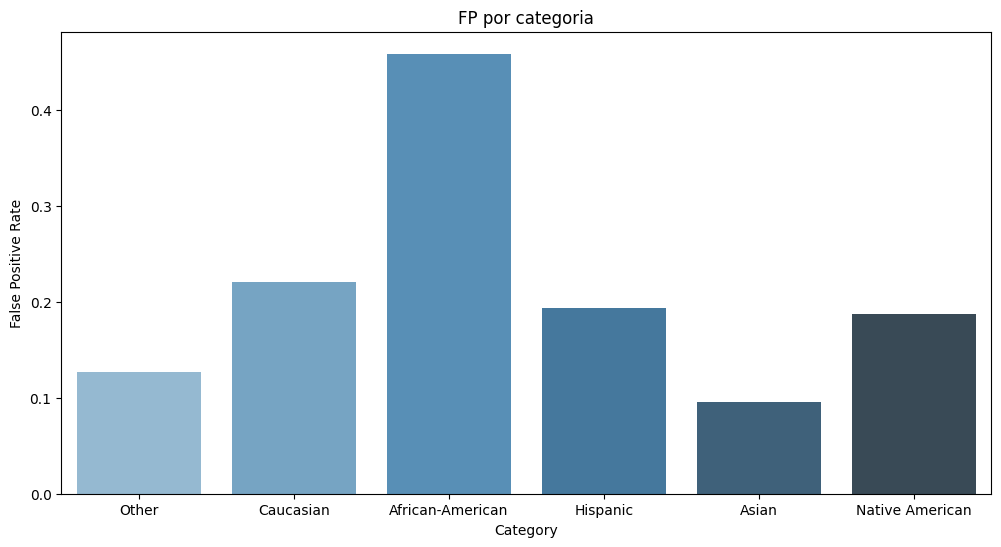

<ipython-input-52-c10536269475>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Negative Rate', data=metrics_df, palette='Reds_d')


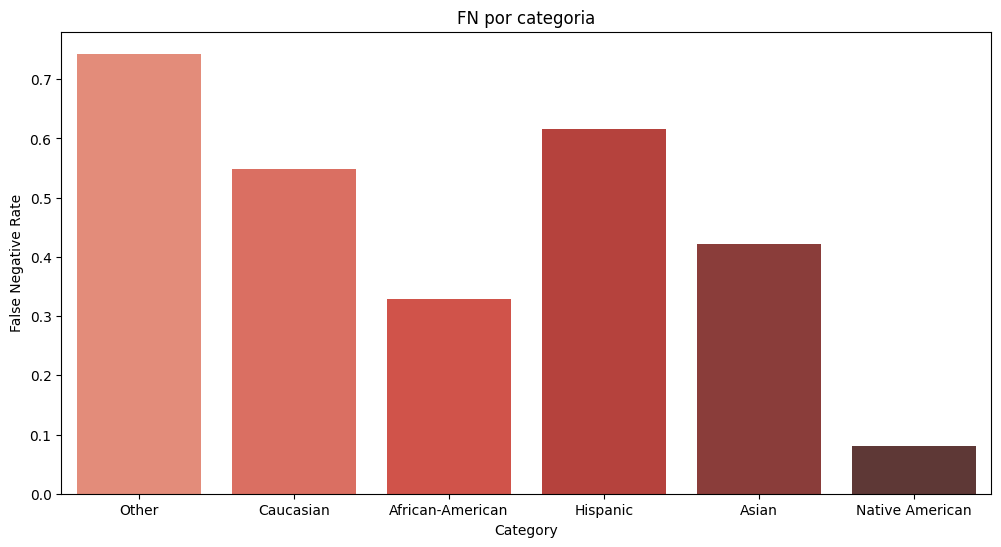

In [57]:
plot_disparities(metrics_df)

**Para el caso de genero:**

Category: Male


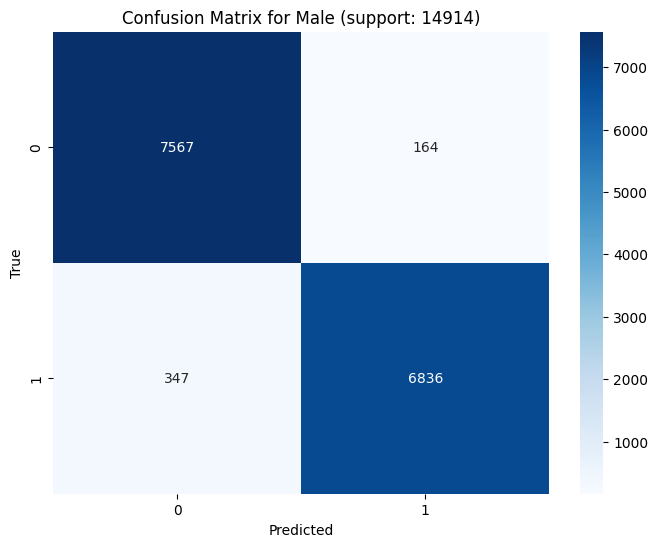

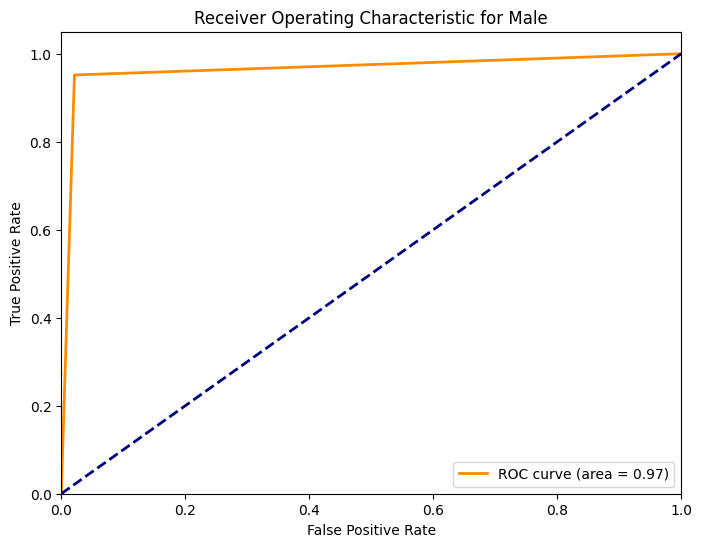

Category: Female


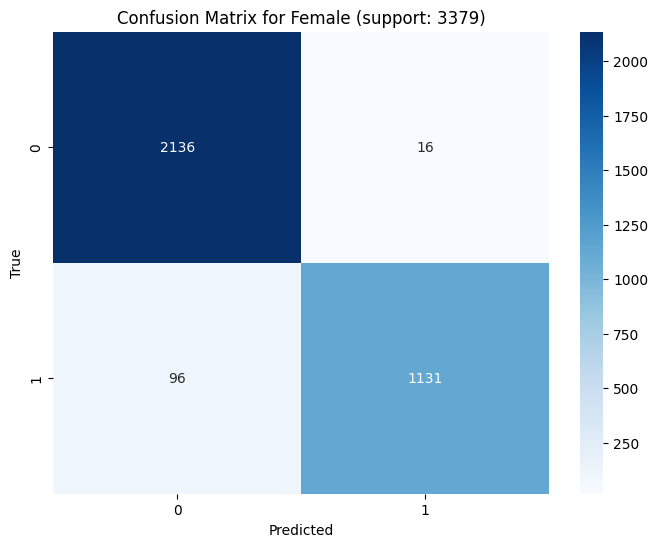

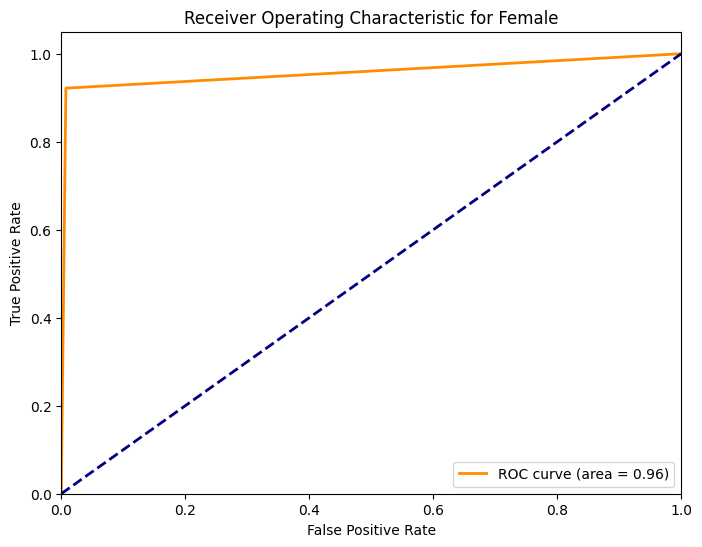

  Category  Precision    Recall  F1-Score  False Positive Rate  \
0     Male   0.976571  0.951691  0.963971             0.021213   
1   Female   0.986051  0.921760  0.952822             0.007435   

   False Negative Rate  
0             0.048309  
1             0.078240  


In [58]:
metrics =  MetricsByCategory(data, 'custom_recid', 'is_recid', 'sex')
metrics_df = metrics.analyze_by_category()
print(metrics_df)

<ipython-input-52-c10536269475>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Positive Rate', data=metrics_df, palette='Blues_d')


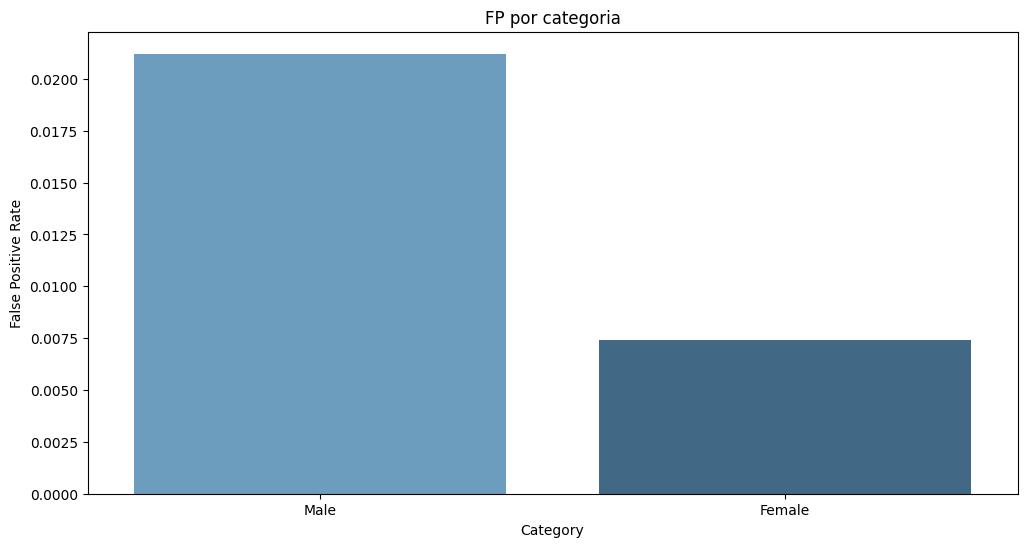

<ipython-input-52-c10536269475>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Negative Rate', data=metrics_df, palette='Reds_d')


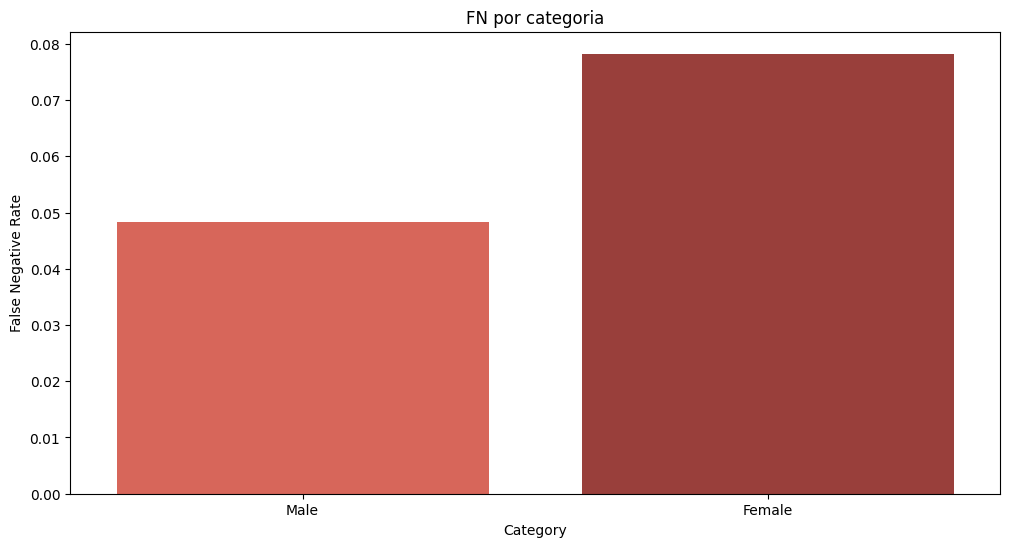

In [59]:
plot_disparities(metrics_df)

Category: Male


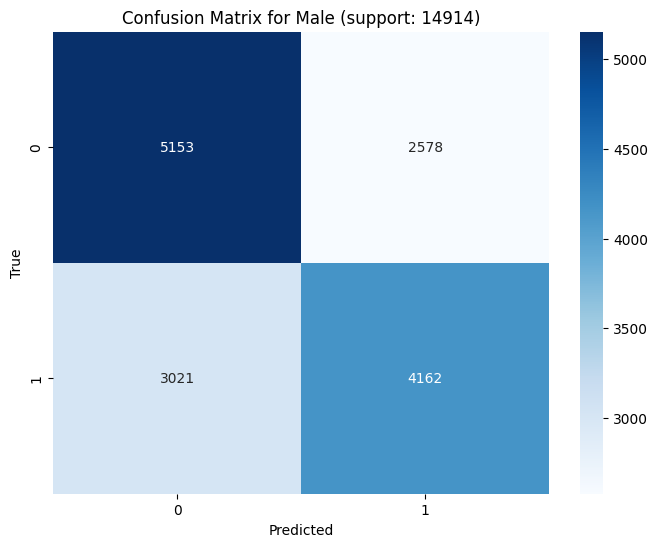

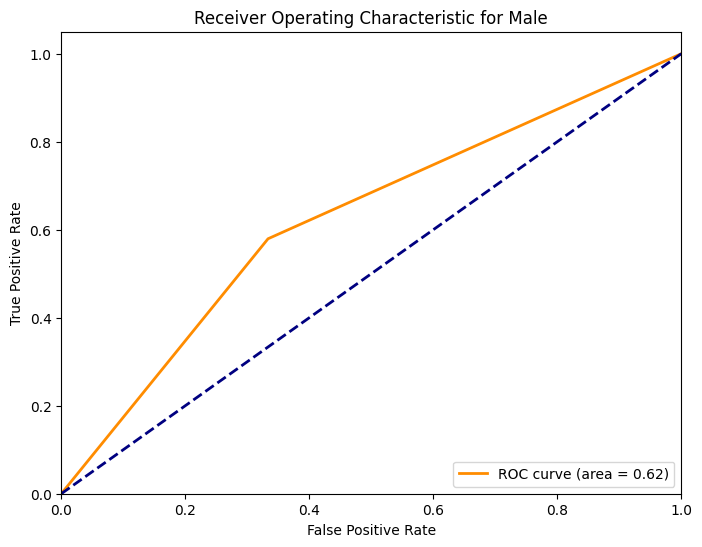

Category: Female


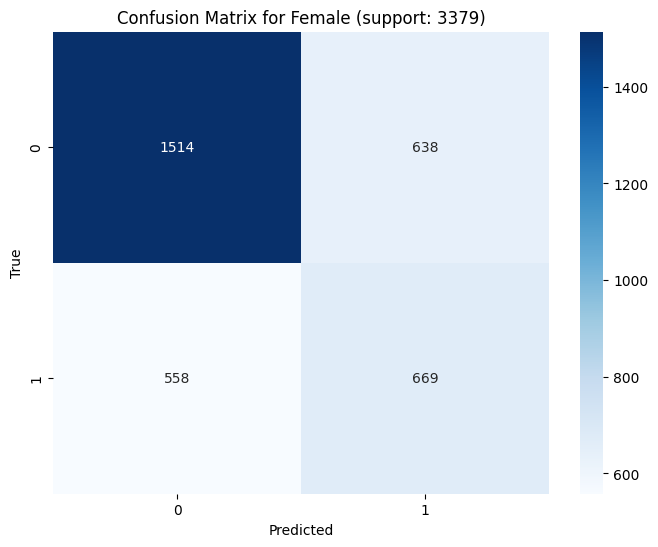

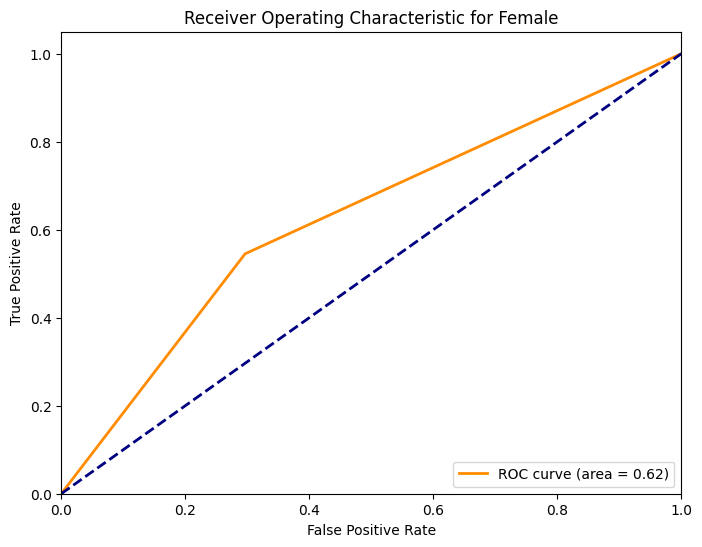

  Category  Precision    Recall  F1-Score  False Positive Rate  \
0     Male   0.617507  0.579424  0.597860             0.333463   
1   Female   0.511859  0.545232  0.528019             0.296468   

   False Negative Rate  
0             0.420576  
1             0.454768  


In [60]:
metrics =  MetricsByCategory(data, 'compas_recid', 'is_recid', 'sex')
metrics_df = metrics.analyze_by_category()
print(metrics_df)

<ipython-input-52-c10536269475>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Positive Rate', data=metrics_df, palette='Blues_d')


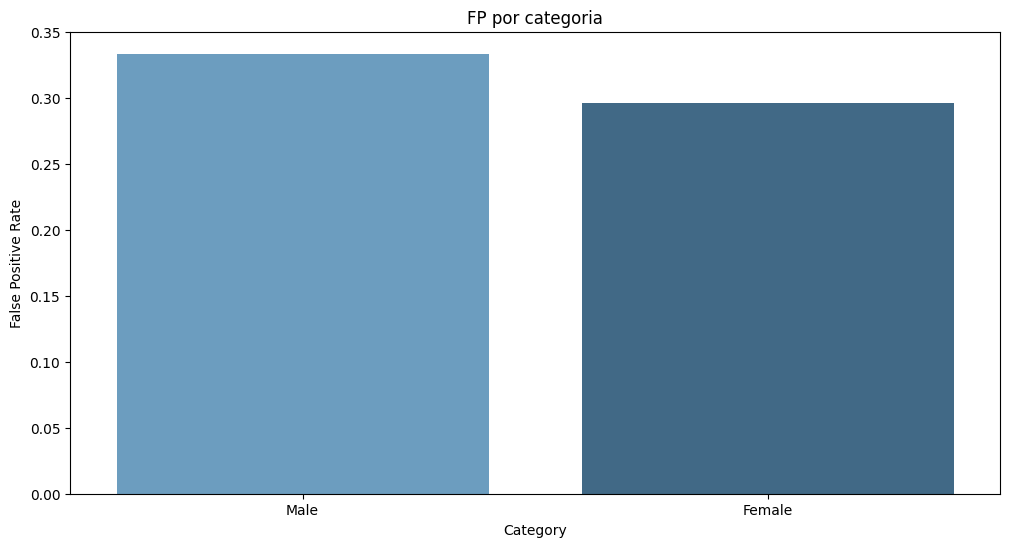

<ipython-input-52-c10536269475>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y='False Negative Rate', data=metrics_df, palette='Reds_d')


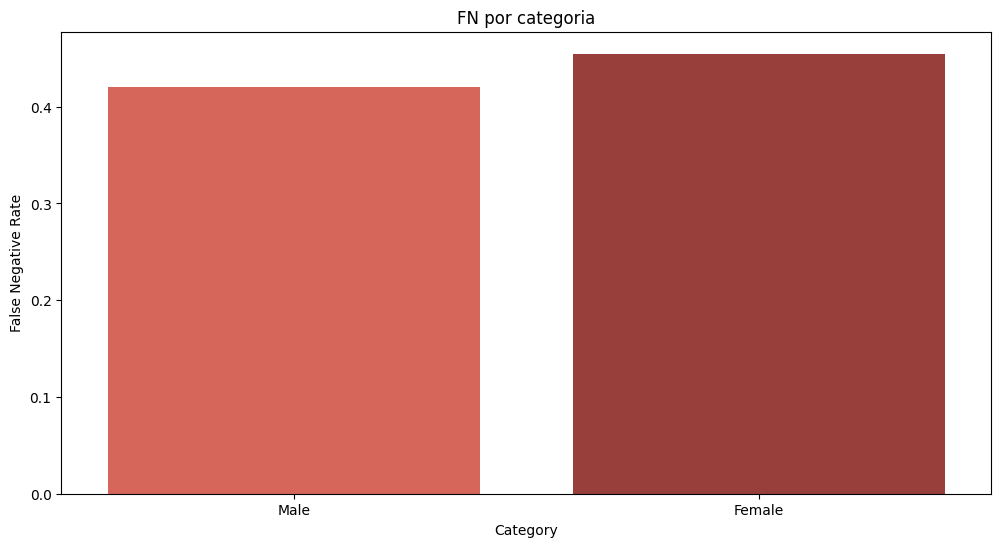

In [61]:
plot_disparities(metrics_df)


# **Conclusiones sobre el Sesgo del Algoritmo COMPAS**

Como conclusiones, se observa un claro sesgo de raza por parte del algoritmo COMPAS con un umbral de 5 para la puntuación que este daba a cada muestra. Este sesgo se visualiza claramente en las gráficas de falsos positivos (FP) y falsos negativos (FN) por raza, comparadas con las mismas gráficas para el algoritmo o modelo "custom" entrenado. En particular, para los afroamericanos, la tasa de FP es de varios órdenes de magnitud mayor que en el modelo "custom". Por otro lado, la tasa de FN es menor para los afroamericanos que para otras razas, lo que indica que el modelo COMPAS tiende a clasificar a los afroamericanos como "1" (reincidentes) con mayor frecuencia.

Estas conclusiones son menos acusadas o casi indetectables cuando se consideran los géneros, donde la tasa de error es menor en comparación con la raza y además es semejante entre ambos sexos. Esto sugiere que el sesgo del modelo COMPAS es más pronunciado en función de la raza que del género.

**Recomendaciones para Abordar los Sesgos Identificados en el Modelo COMPAS**

1. **Revisar y Mejorar los Datos de Entrenamiento**
   - **Recolección de Datos Representativos**: Asegurarse de que los datos de entrenamiento sean representativos de toda la población y no estén sesgados hacia un grupo particular.
   - **Eliminar Variables Sensibles**: Como he intentando hacer con el modelo custom, hay que considerar eliminar o modificar variables que puedan introducir sesgos directos o indirectos. Sin embargo, esto debe hacerse con precaución, ya que puede haber variables correlacionadas que también introduzcan sesgos. Por ello es importante el estudio de la correlación tanto lineal (pearson) como no lineal.
   - **Análisis Exploratorio de Datos**: Realizar un análisis de los datos para identificar posibles fuentes de sesgo y corregirlas antes del entrenamiento.

2. **Ajustar el Algoritmo**
   - **Ajustar Umbrales de Decisión**: Modificar el umbral de decisión puede disminuir el sesgo del modelo sobre cierta dimensión o feature y así equilibrar las tasas de falsos positivos y falsos negativos sobre esta feature.
   - **Optimización Multicriterio**: Un paso mas avanzado sería incluir métricas de equidad en el proceso de optimización del modelo, no solo precisión y recall. Esto podría implicar el uso de algoritmos que consideran la equidad como parte del objetivo de optimización.

3. **Utilizar Algoritmos de Mitigación de Sesgo**
   - **Reweighing**: Aplicar técnicas de reweighing que ajustan las ponderaciones de los datos de entrenamiento para reducir el sesgo.
   - **Fairness Constraints**: Utilizar algoritmos de aprendizaje automático que incorporan restricciones de equidad, como Fairness-aware Machine Learning (FairML), para asegurar que las predicciones sean equitativas.

4. **Transparencia y Explicabilidad**
   - **Explicabilidad del Modelo**: Utilizar técnicas de explicabilidad de modelos (como SHAP o LIME) para entender cómo el modelo toma decisiones y asegurar que no está utilizando características que podrían introducir sesgo.
